In [31]:
%cd /home/Reguformer/notebooks

/home/Reguformer/notebooks


In [32]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

from tqdm import tqdm

warnings.filterwarnings("ignore")

from trans_oil_gas import utils_fix_seeds, utils_cv, utils_model, utils_model_training, utils_dataset

Set parameters for plots.

In [33]:
plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Choose GPU device if it is available.

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gpu = [0] if 'cuda' in device.type else 0
device, gpu

(device(type='cuda', index=0), [0])

Fix all possible seeds for results reproducibility.

In [35]:
utils_fix_seeds.fix_seeds(device=device)

In [36]:
saves_all_res = './saves_inference_time'

if not os.path.exists(saves_all_res):
    os.mkdir(saves_all_res)

# Read data

Reading of already preprocessed data (here synthetic dataset with the same columns as in the original one is presented).

In [37]:
df = pd.read_csv('../data/synthetic_well_log_data.csv')
df

,DRHO,DENS,GR,DTC,WELLNAME
0,0.01778,2.3794,1.214982,101.5516,26
1,0.01701,2.3705,1.086457,101.6722,26
2,0.01624,2.3615,0.957933,101.7928,26
3,0.01779,2.3593,0.493992,101.1051,26
4,0.02008,2.3591,-0.076734,100.1601,26
...,...,...,...,...,...
730,0.11269,2.6161,0.742381,92.0410,127
731,0.11269,2.6161,0.775581,92.1752,127
732,0.11269,2.6161,0.686798,91.6055,127
733,0.11269,2.6161,0.614402,91.7522,127


# Generate datasets

In [38]:
# results_len_train = 25000
# results_len_test = 5000
# slice_len = 100
results_len_train = 2500
results_len_test = 500
slice_len = 100

In [39]:
df["WELLNAME"].nunique()

4

## Train test split

In [40]:
train_wells = np.random.choice(
    df["WELLNAME"].unique(), 
    # size=14, 
    size=2, 
    replace=False
)
train_wells.sort()
train_wells

array([ 35, 127])

In [41]:
test_wells = np.array(list(set(df["WELLNAME"].unique()) - set(train_wells)))
test_wells.sort()
test_wells

array([ 26, 126])

In [42]:
train_df = df[df["WELLNAME"].isin(train_wells)]
test_df = df[df["WELLNAME"].isin(test_wells)]

(sorted(train_df["WELLNAME"].unique()) == train_wells).sum(), (sorted(test_df["WELLNAME"].unique()) == test_wells).sum()

(2, 2)

## Dataset and dataloader generation

In [43]:
train_slice_dataset, val_slice_dataset = utils_dataset.generate_datasets(
    train_df, 
    test_df,
    well_column="WELLNAME",
    slice_len=slice_len, 
    path_to_saves=saves_all_res,
    results_len_train=results_len_train,
    results_len_test=results_len_test,
)

In [44]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(
    val_slice_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [45]:
val_example, _, _, _ = next(iter(val_dataloader))
val_example.shape

torch.Size([64, 100, 4])

# Models with the same hyperparameters

In [46]:
input_size = 4
batch_size = 64

In [47]:
fixed_params_reguformer = {
    "enc_in": 4,
    "distil": None,
    "device": device,
    "attn": "prob",
    "activation": "gelu",
    "output_attention": False,
    "n_seq": 100,
}
most_common_params = {
    'd_model': 16,
    'factor': 9,
    'n_heads': 4,
    'dropout': 0.15,
    'd_ff': 512,
    'e_layers': 2
}
all_reg_strategies = [
    'topQ-siamese', 
    'randQ-siamese',
    'topK-siamese',
    'randK-siamese',
    'topQ_topK-siamese',
    'topQ_randK-siamese',
    'randQ_topK-siamese',
    'randQ_randK-siamese',
    'topQ-triplet',
    'randQ-triplet',
    'topK-triplet',
    'randK-triplet',
    'topQ_topK-triplet',
    'topQ_randK-triplet',
    'randQ_topK-triplet',
    'randQ_randK-triplet',
]

In [48]:
path_to_models = "./saves_reguformers_with_same_params/"

# Models quality and inference time

In [49]:
calc_f1 = lambda precision, recall: 2 * (precision * recall) / (precision + recall)

In [50]:
main_metric_names = ["Accuracy", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"]

In [51]:
def inference_cuda(model, inputs, warmup, iterations):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    timings = np.zeros(iterations)

    with torch.no_grad():  
        # GPU-WARM-UP
        for _ in range(warmup):
            _ = model(inputs)
        torch.cuda.synchronize()
        # MEASURE PERFORMANCE
        for rep in range(iterations):
            starter.record()
            _ = model(inputs)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[rep] = curr_time

    return timings

In [52]:
import torch.backends.cudnn as cudnn

In [ ]:
all_res = []

cudnn.benchmark = True
cudnn.deterministic = False

for model_type in all_reg_strategies:
    print('model_type', model_type)
    model_res = {"model_type": model_type}

    reg_type, loss_type = model_type.split("-")
    model_res["reg_type"] = reg_type
    model_res["loss_type"] = loss_type

    # load model
    print('load model')
    PATH = os.path.join(
        path_to_models, 
        "{}_{}.pth".format(loss_type, reg_type)
    )
    
    if 'siamese' in model_type:
        model = utils_model.SiameseArchitecture(encoder_type="reguformer", sparsification_type=reg_type, fc_hidden_size=64, **fixed_params_reguformer, **most_common_params).float()
        input_inference_time = (torch.tensor(val_example), torch.tensor(val_example))
        
    elif 'triplet' in model_type:
        model = utils_model.TripletArchitecture(encoder_type="reguformer", sparsification_type=reg_type, **fixed_params_reguformer, **most_common_params).float()
        input_inference_time = torch.tensor(val_example)
        
    model.load_state_dict(torch.load(PATH, map_location=device))
    print('model loaded')
    model.eval()

    # get model's quality and time on val_slice_dataset
    similarity_model = utils_model.IntervalModel(
        model=model,
        model_type=model_type,
        train_data=None,
        test_data=val_slice_dataset,
        batch_size=batch_size,
    )
    # get array of inference times
    time_array = inference_cuda(
        similarity_model.model, 
        input_inference_time, 
        warmup=2, 
        iterations=3,
        # warmup=20, 
        # iterations=300,
    )
    print(f"Time {time_array.mean()} +/- {time_array.std()}")
    model_res["gpu_inference_time_mean"] = time_array.mean()
    model_res["gpu_inference_time_std"] = time_array.std()
    
    # get model's quality using Euclidean or cosinedistance
    for distance_name in ["euclidean", "cosine"]:
        metrics = utils_cv.calculate_distance(
            similarity_model.model,
            val_slice_dataset,
            distance_type=distance_name,
        )
        (
            roc_auc,
            pr_auc,
            acc,
            precision,
            recall,
        ) = metrics
        f1 = calc_f1(precision, recall)
        for metric_name, metric_data in zip(
            main_metric_names, # ["Accuracy", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"]
            [acc, precision, recall, f1, roc_auc, pr_auc],
        ):
            model_res[distance_name + "_" + metric_name] = metric_data
    
    if "siamese" in model_type:
        # get Siamese model's quality with 3 FC
        metrics_nn = utils_model_training.test_nn_model(
            similarity_model, val_slice_dataset, return_metrics=True
        )

        acc, roc_auc, pr_auc, conf_matrix = metrics_nn[2]
        tn, fp, fn, tp = conf_matrix.ravel()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = calc_f1(precision, recall)
        
        for metric_name, metric_data in zip(
            main_metric_names, # ["Accuracy", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"]
            [acc, precision, recall, f1, roc_auc, pr_auc],
        ):
            model_res[metric_name] = metric_data
   
    all_res.append(model_res)

    print('-'*100)

In [ ]:
all_res_df = pd.DataFrame(all_res)
all_res_df.to_excel(os.path.join(saves_all_res, 'inference_time_same_params_gpu.xlsx'), index=False)

In [ ]:
all_res_df

,model_type,reg_type,loss_type,gpu_inference_time_mean,gpu_inference_time_std,euclidean_Accuracy,euclidean_Precision,euclidean_Recall,euclidean_F1,euclidean_ROC AUC,...,cosine_Recall,cosine_F1,cosine_ROC AUC,cosine_PR AUC,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
0,topQ-siamese,topQ,siamese,169.780352,54.911644,1.000000,1.0,0.916,0.956159,0.958,...,1.00,1.000000,1.00,1.000000,1.000,1.0,1.000,1.000000,1.0,1.0
1,randQ-siamese,randQ,siamese,568.507294,45.559550,1.000000,1.0,0.586,0.738966,0.793,...,1.00,1.000000,1.00,1.000000,0.615,1.0,0.230,0.373984,1.0,1.0
2,topK-siamese,topK,siamese,483.326833,58.585770,1.000000,1.0,0.878,0.935037,0.939,...,1.00,1.000000,1.00,1.000000,0.936,1.0,0.872,0.931624,1.0,1.0
3,randK-siamese,randK,siamese,561.521556,125.314422,1.000000,1.0,0.790,0.882682,0.895,...,1.00,1.000000,1.00,1.000000,0.750,1.0,0.500,0.666667,1.0,1.0
4,topQ_topK-siamese,topQ_topK,siamese,231.758077,59.375032,1.000000,1.0,0.912,0.953975,0.956,...,1.00,1.000000,1.00,1.000000,0.750,1.0,0.500,0.666667,1.0,1.0
5,topQ_randK-siamese,topQ_randK,siamese,783.805339,96.681555,0.998125,1.0,0.606,0.754670,0.803,...,0.96,0.979592,0.98,0.999608,0.520,1.0,0.040,0.076923,1.0,1.0
6,randQ_topK-siamese,randQ_topK,siamese,348.785955,247.984569,1.000000,1.0,0.868,0.929336,0.934,...,1.00,1.000000,1.00,1.000000,1.000,1.0,1.000,1.000000,1.0,1.0
7,randQ_randK-siamese,randQ_randK,siamese,369.026154,159.566880,1.000000,1.0,0.690,0.816568,0.845,...,1.00,1.000000,1.00,1.000000,0.982,1.0,0.964,0.981670,1.0,1.0
8,topQ-triplet,topQ,triplet,322.768112,170.078751,1.000000,1.0,0.738,0.849252,0.869,...,1.00,1.000000,1.00,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
9,randQ-triplet,randQ,triplet,109.509471,37.952560,1.000000,1.0,0.628,0.771499,0.814,...,1.00,1.000000,1.00,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


# ______________________________________________________________________________________________________________________________________________________

# Results processing 

In [ ]:
all_res_df = pd.read_excel(os.path.join(saves_all_res, 'inference_time_same_params_gpu.xlsx'))
all_res_df

,model_type,reg_type,loss_type,gpu_inference_time_mean,gpu_inference_time_std,euclidean_Accuracy,euclidean_Precision,euclidean_Recall,euclidean_F1,euclidean_ROC AUC,...,cosine_Recall,cosine_F1,cosine_ROC AUC,cosine_PR AUC,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
0,topQ-siamese,topQ,siamese,169.780352,54.911644,1.000000,1,0.916,0.956159,0.958,...,1.00,1.000000,1.00,1.000000,1.000,1.0,1.000,1.000000,1.0,1.0
1,randQ-siamese,randQ,siamese,568.507294,45.559550,1.000000,1,0.586,0.738966,0.793,...,1.00,1.000000,1.00,1.000000,0.615,1.0,0.230,0.373984,1.0,1.0
2,topK-siamese,topK,siamese,483.326833,58.585770,1.000000,1,0.878,0.935037,0.939,...,1.00,1.000000,1.00,1.000000,0.936,1.0,0.872,0.931624,1.0,1.0
3,randK-siamese,randK,siamese,561.521556,125.314422,1.000000,1,0.790,0.882682,0.895,...,1.00,1.000000,1.00,1.000000,0.750,1.0,0.500,0.666667,1.0,1.0
4,topQ_topK-siamese,topQ_topK,siamese,231.758077,59.375032,1.000000,1,0.912,0.953975,0.956,...,1.00,1.000000,1.00,1.000000,0.750,1.0,0.500,0.666667,1.0,1.0
5,topQ_randK-siamese,topQ_randK,siamese,783.805339,96.681555,0.998125,1,0.606,0.754670,0.803,...,0.96,0.979592,0.98,0.999608,0.520,1.0,0.040,0.076923,1.0,1.0
6,randQ_topK-siamese,randQ_topK,siamese,348.785955,247.984569,1.000000,1,0.868,0.929336,0.934,...,1.00,1.000000,1.00,1.000000,1.000,1.0,1.000,1.000000,1.0,1.0
7,randQ_randK-siamese,randQ_randK,siamese,369.026154,159.566880,1.000000,1,0.690,0.816568,0.845,...,1.00,1.000000,1.00,1.000000,0.982,1.0,0.964,0.981670,1.0,1.0
8,topQ-triplet,topQ,triplet,322.768112,170.078751,1.000000,1,0.738,0.849252,0.869,...,1.00,1.000000,1.00,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
9,randQ-triplet,randQ,triplet,109.509471,37.952560,1.000000,1,0.628,0.771499,0.814,...,1.00,1.000000,1.00,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
loss_type_legend_dict = {
    "siamese": "Siam.",
    "triplet": "Tripl.",
}

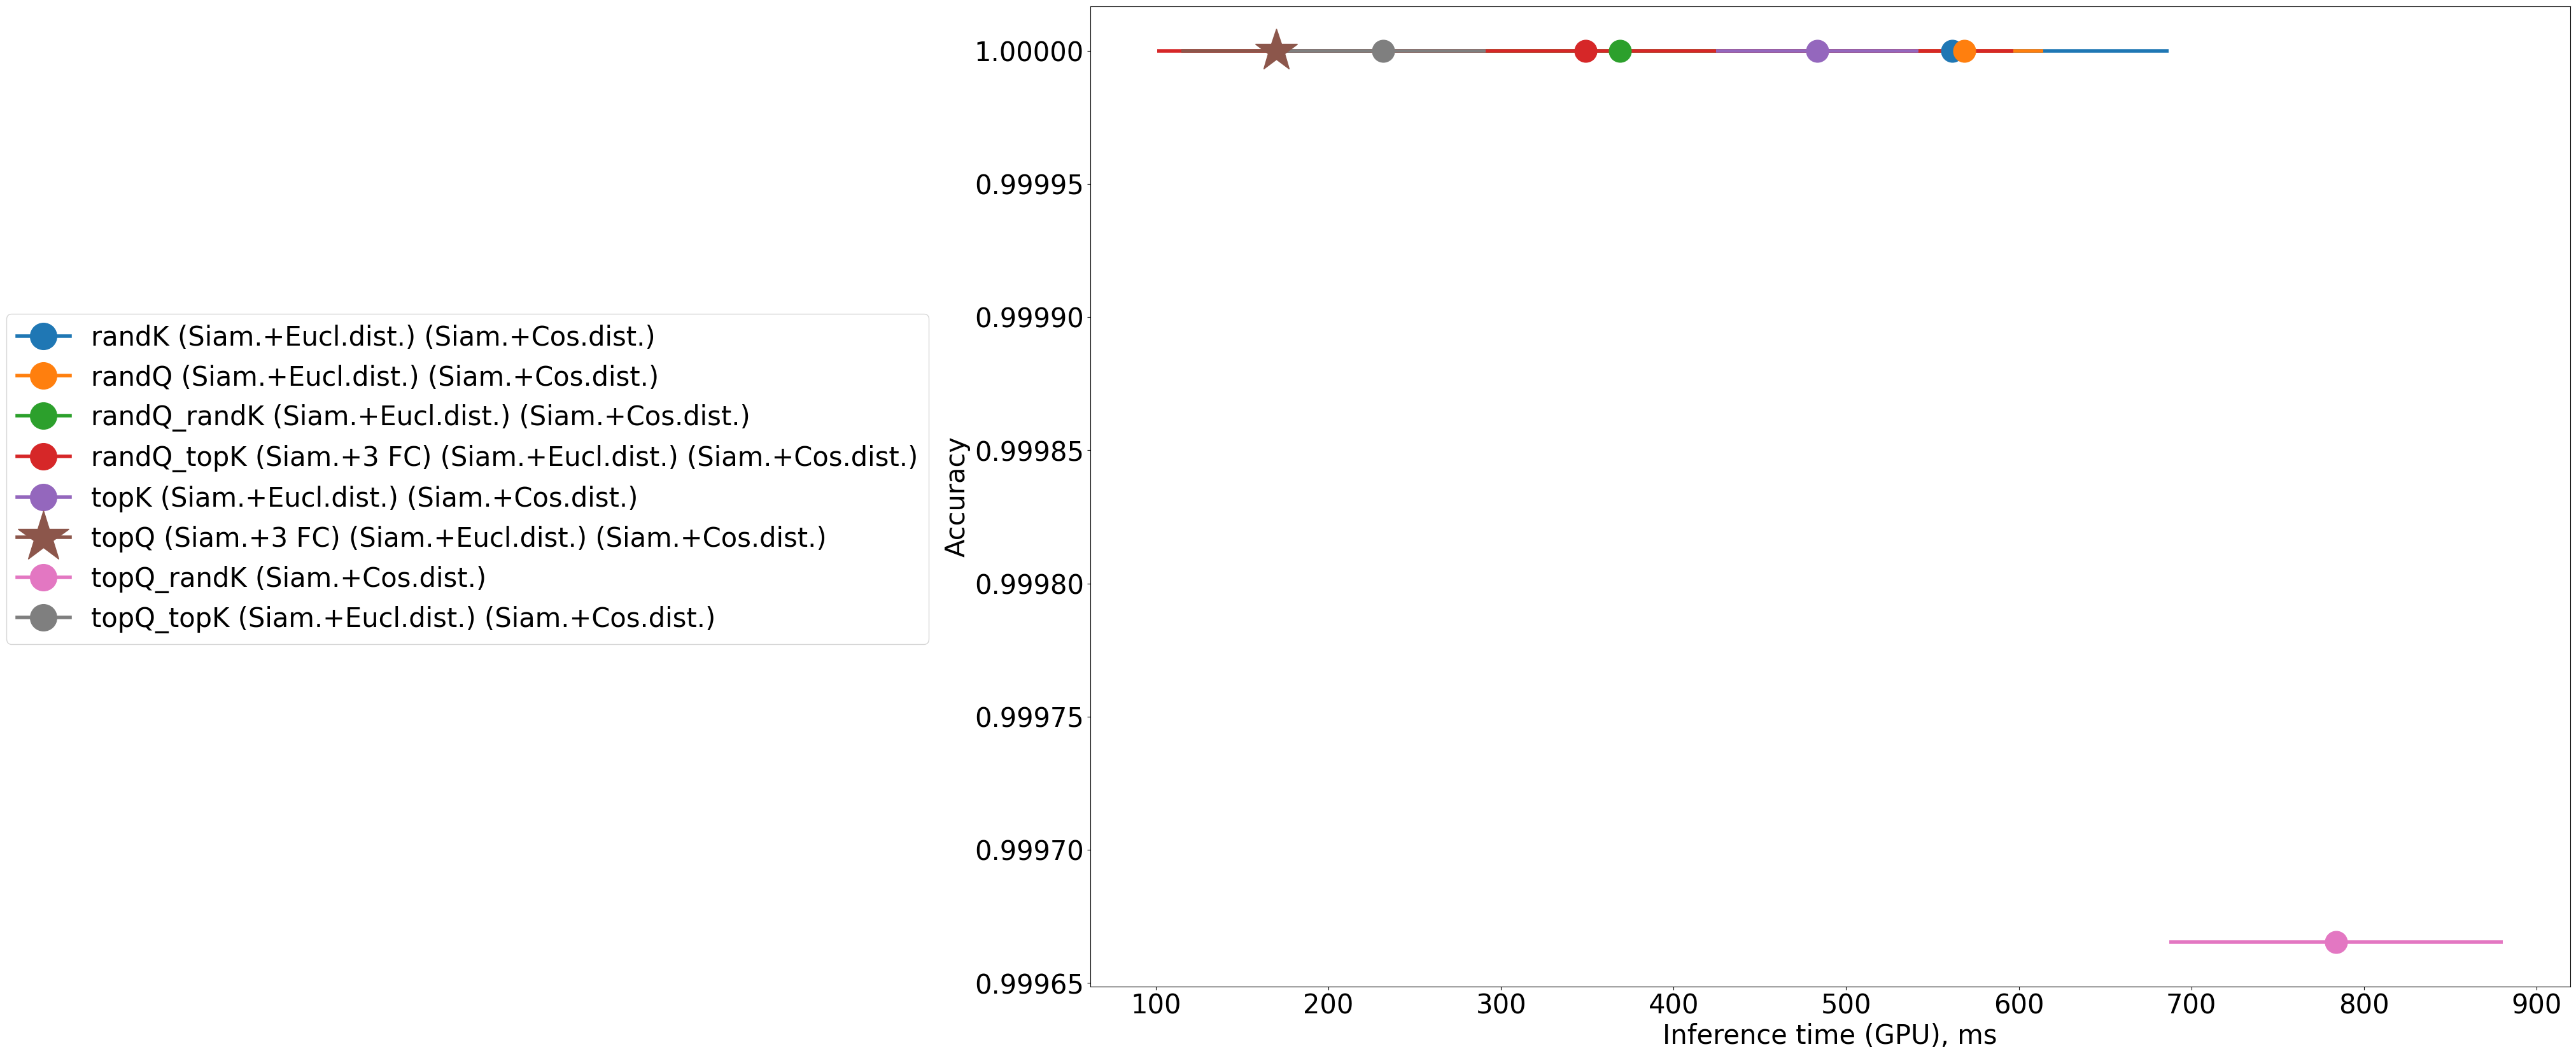

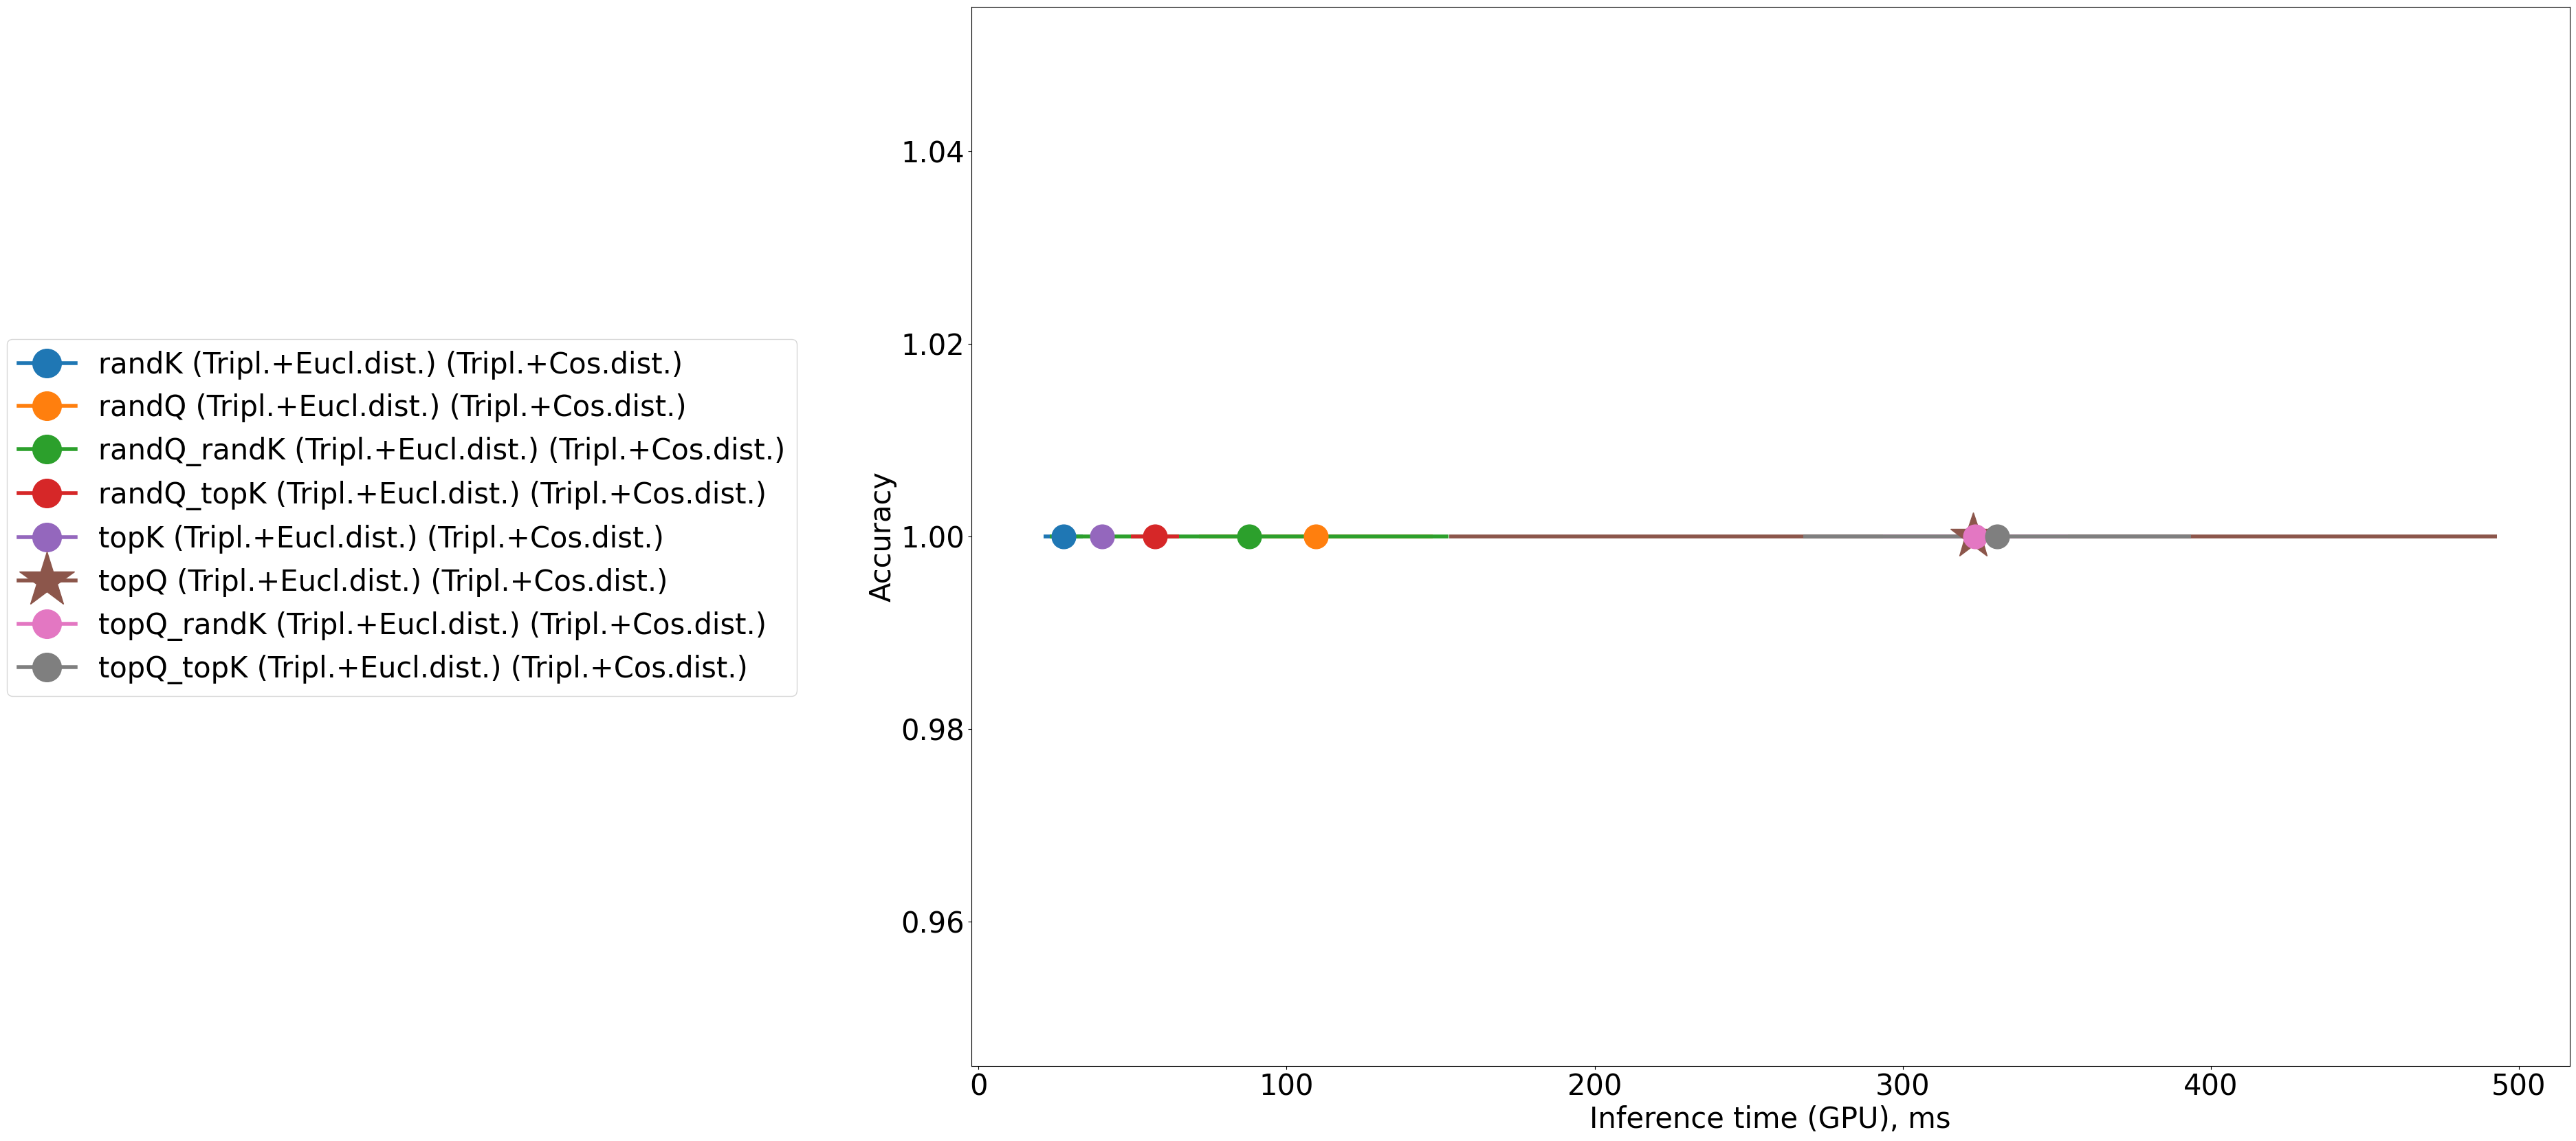

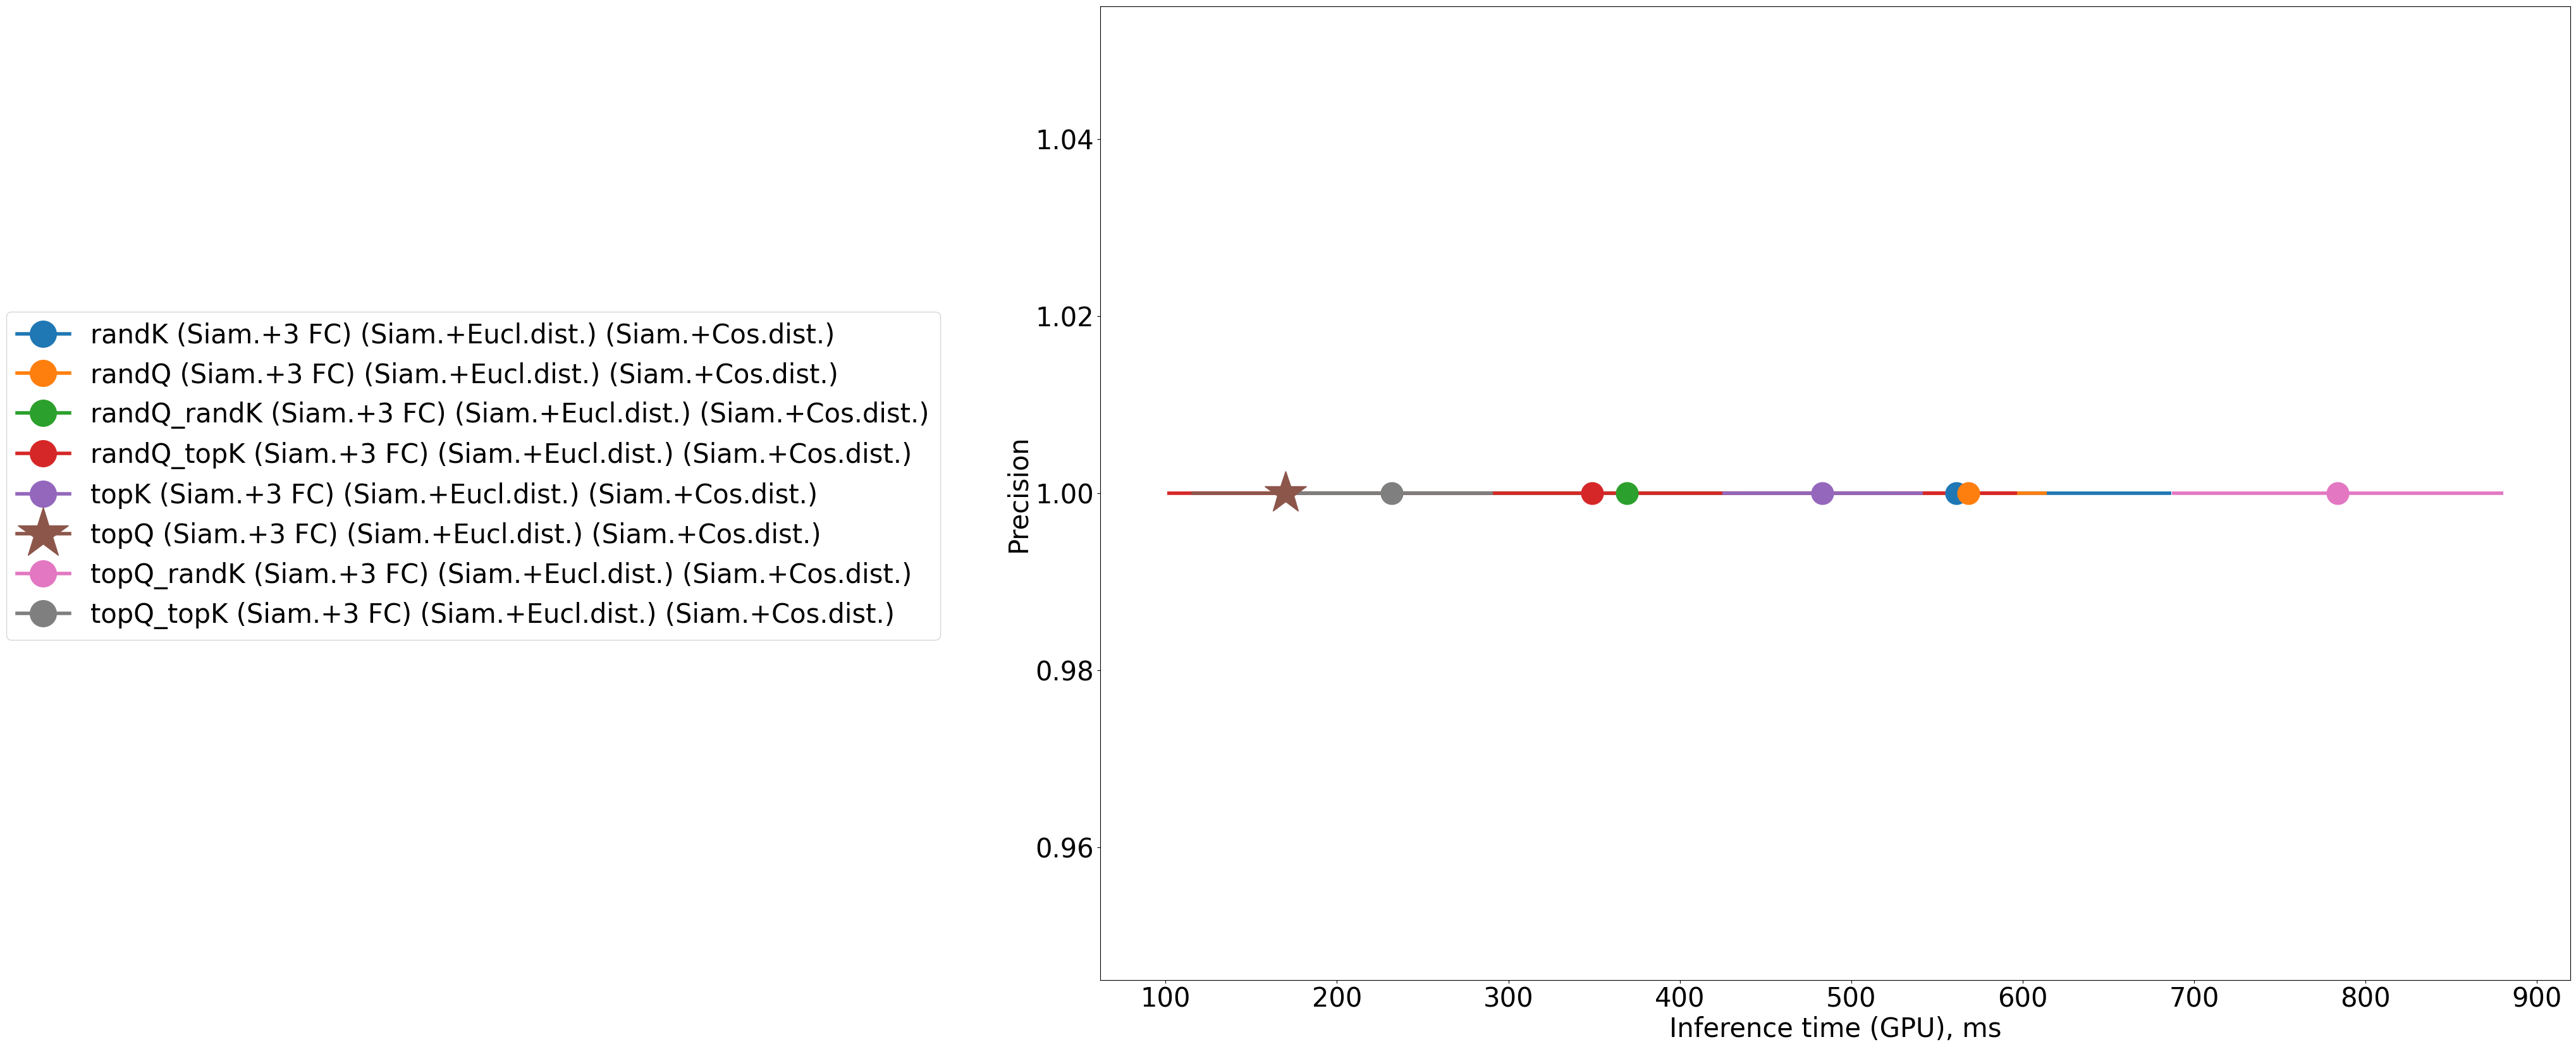

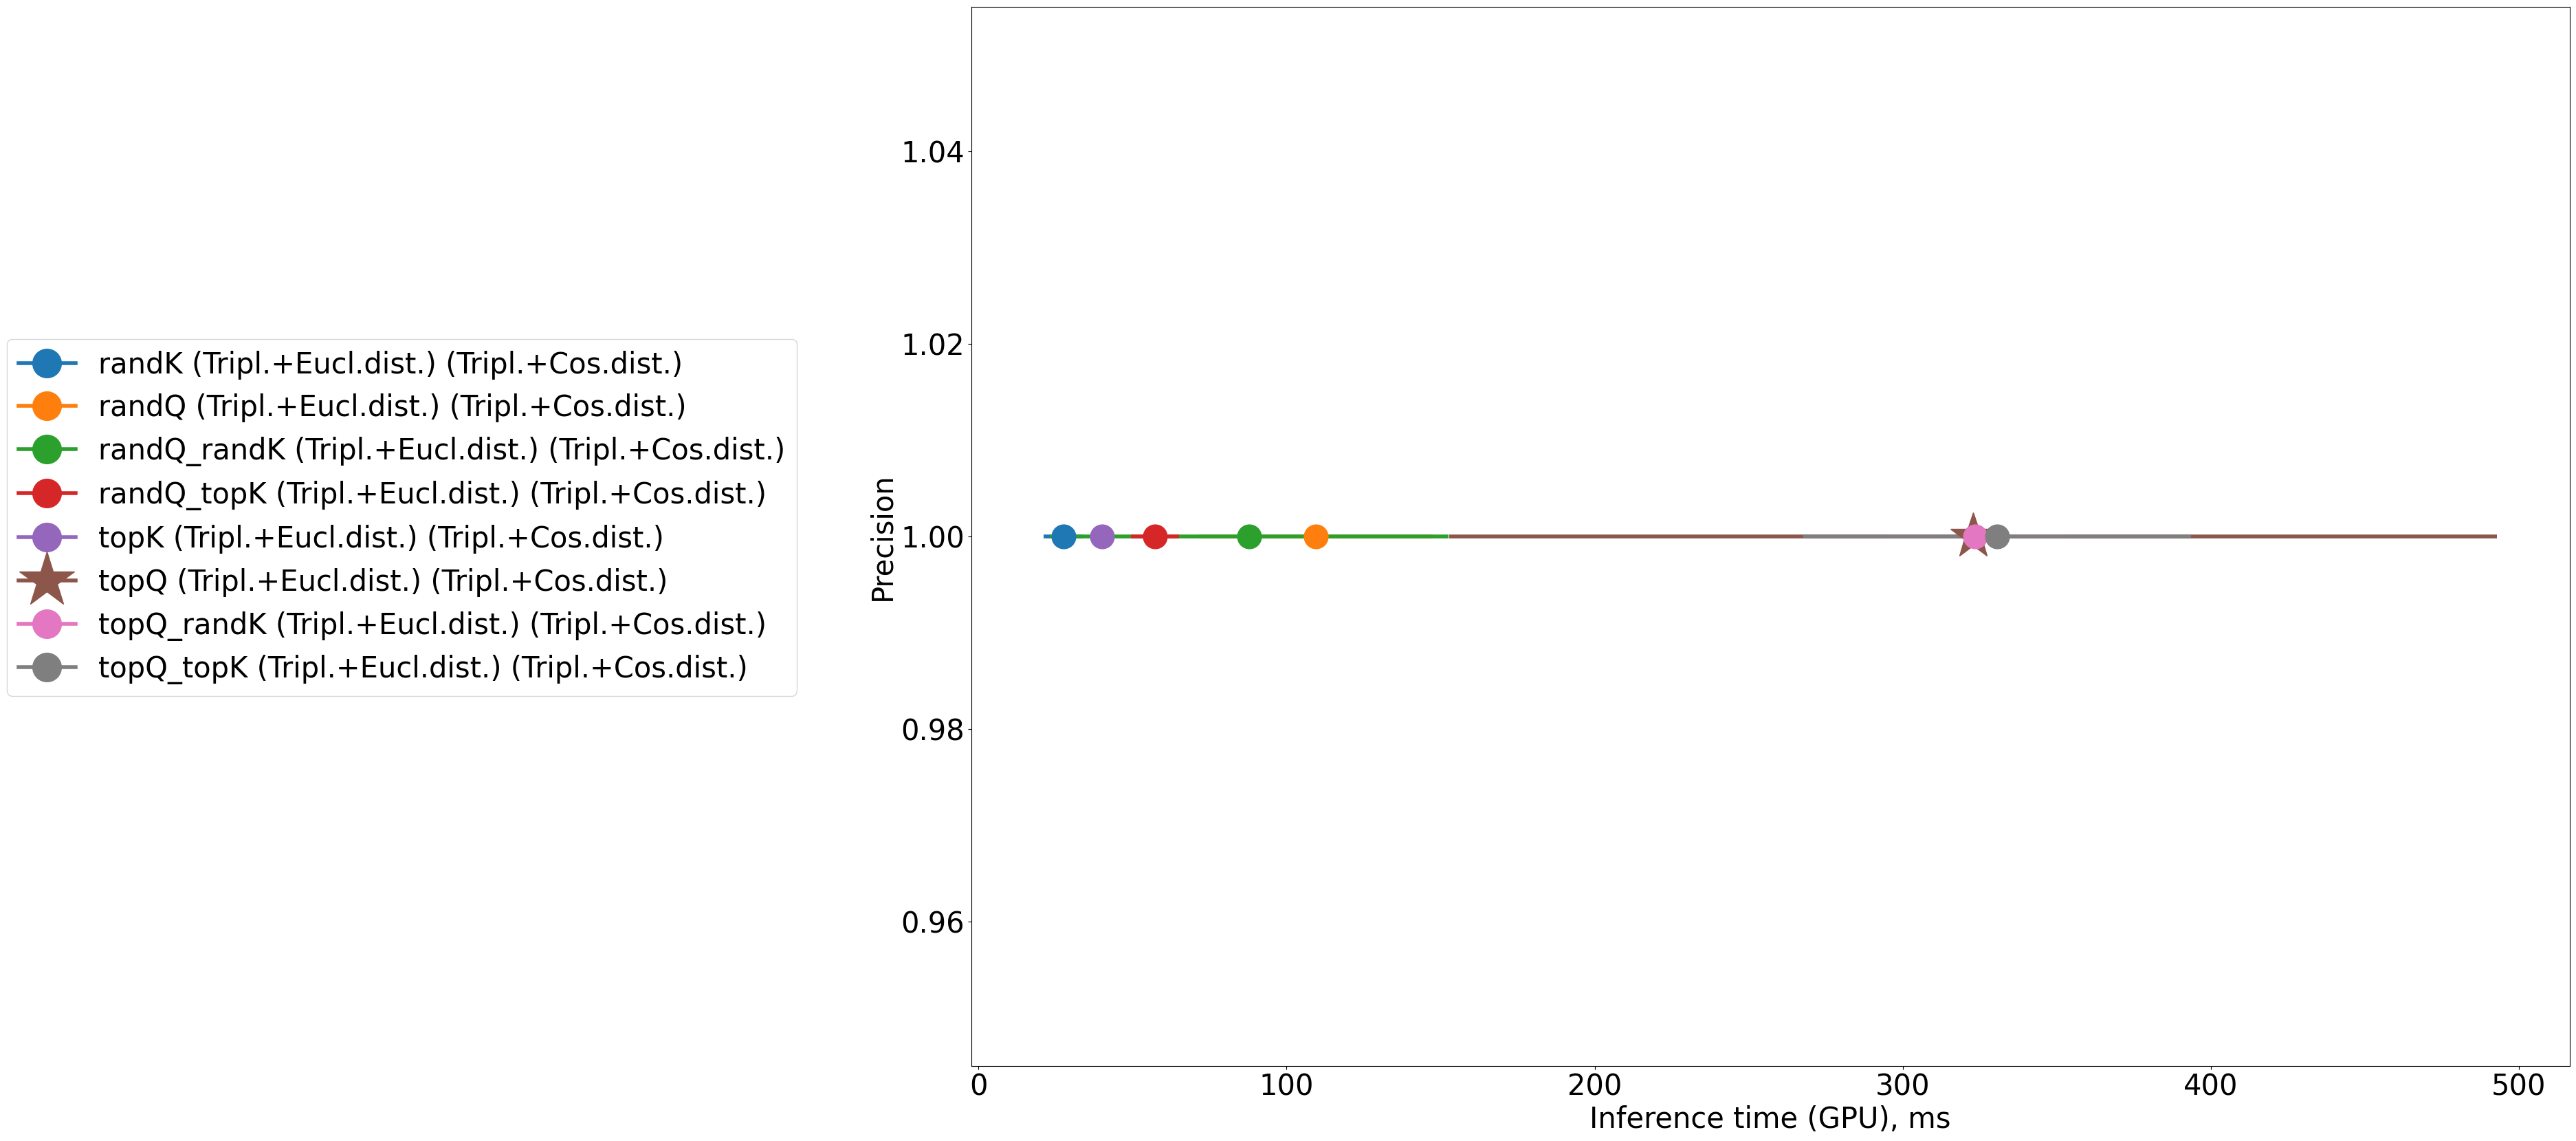

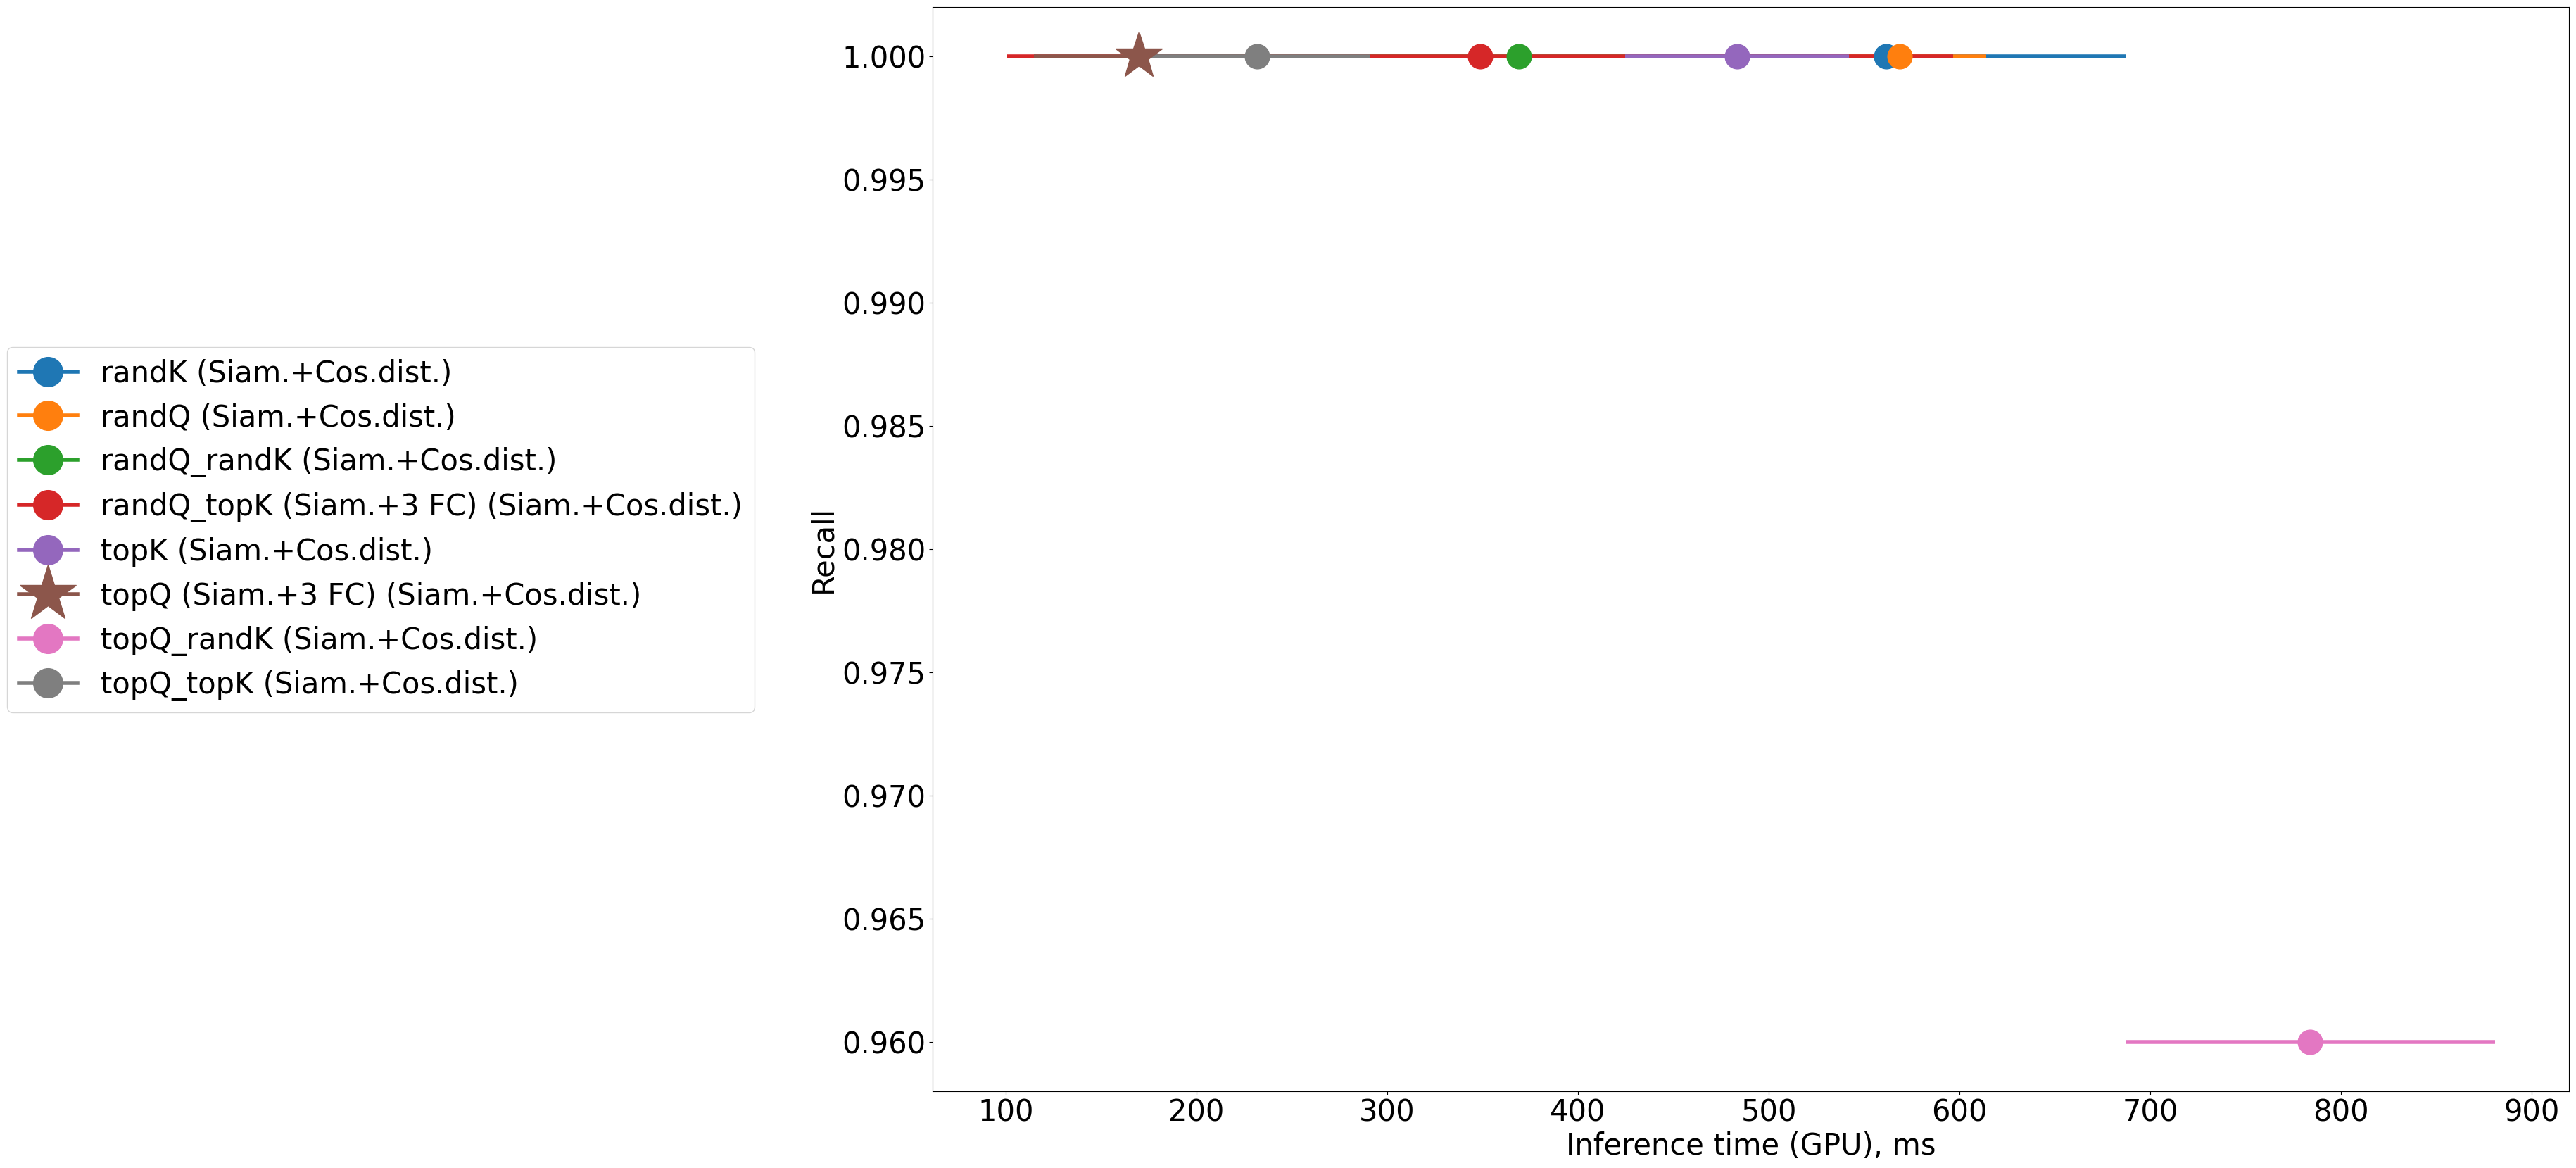

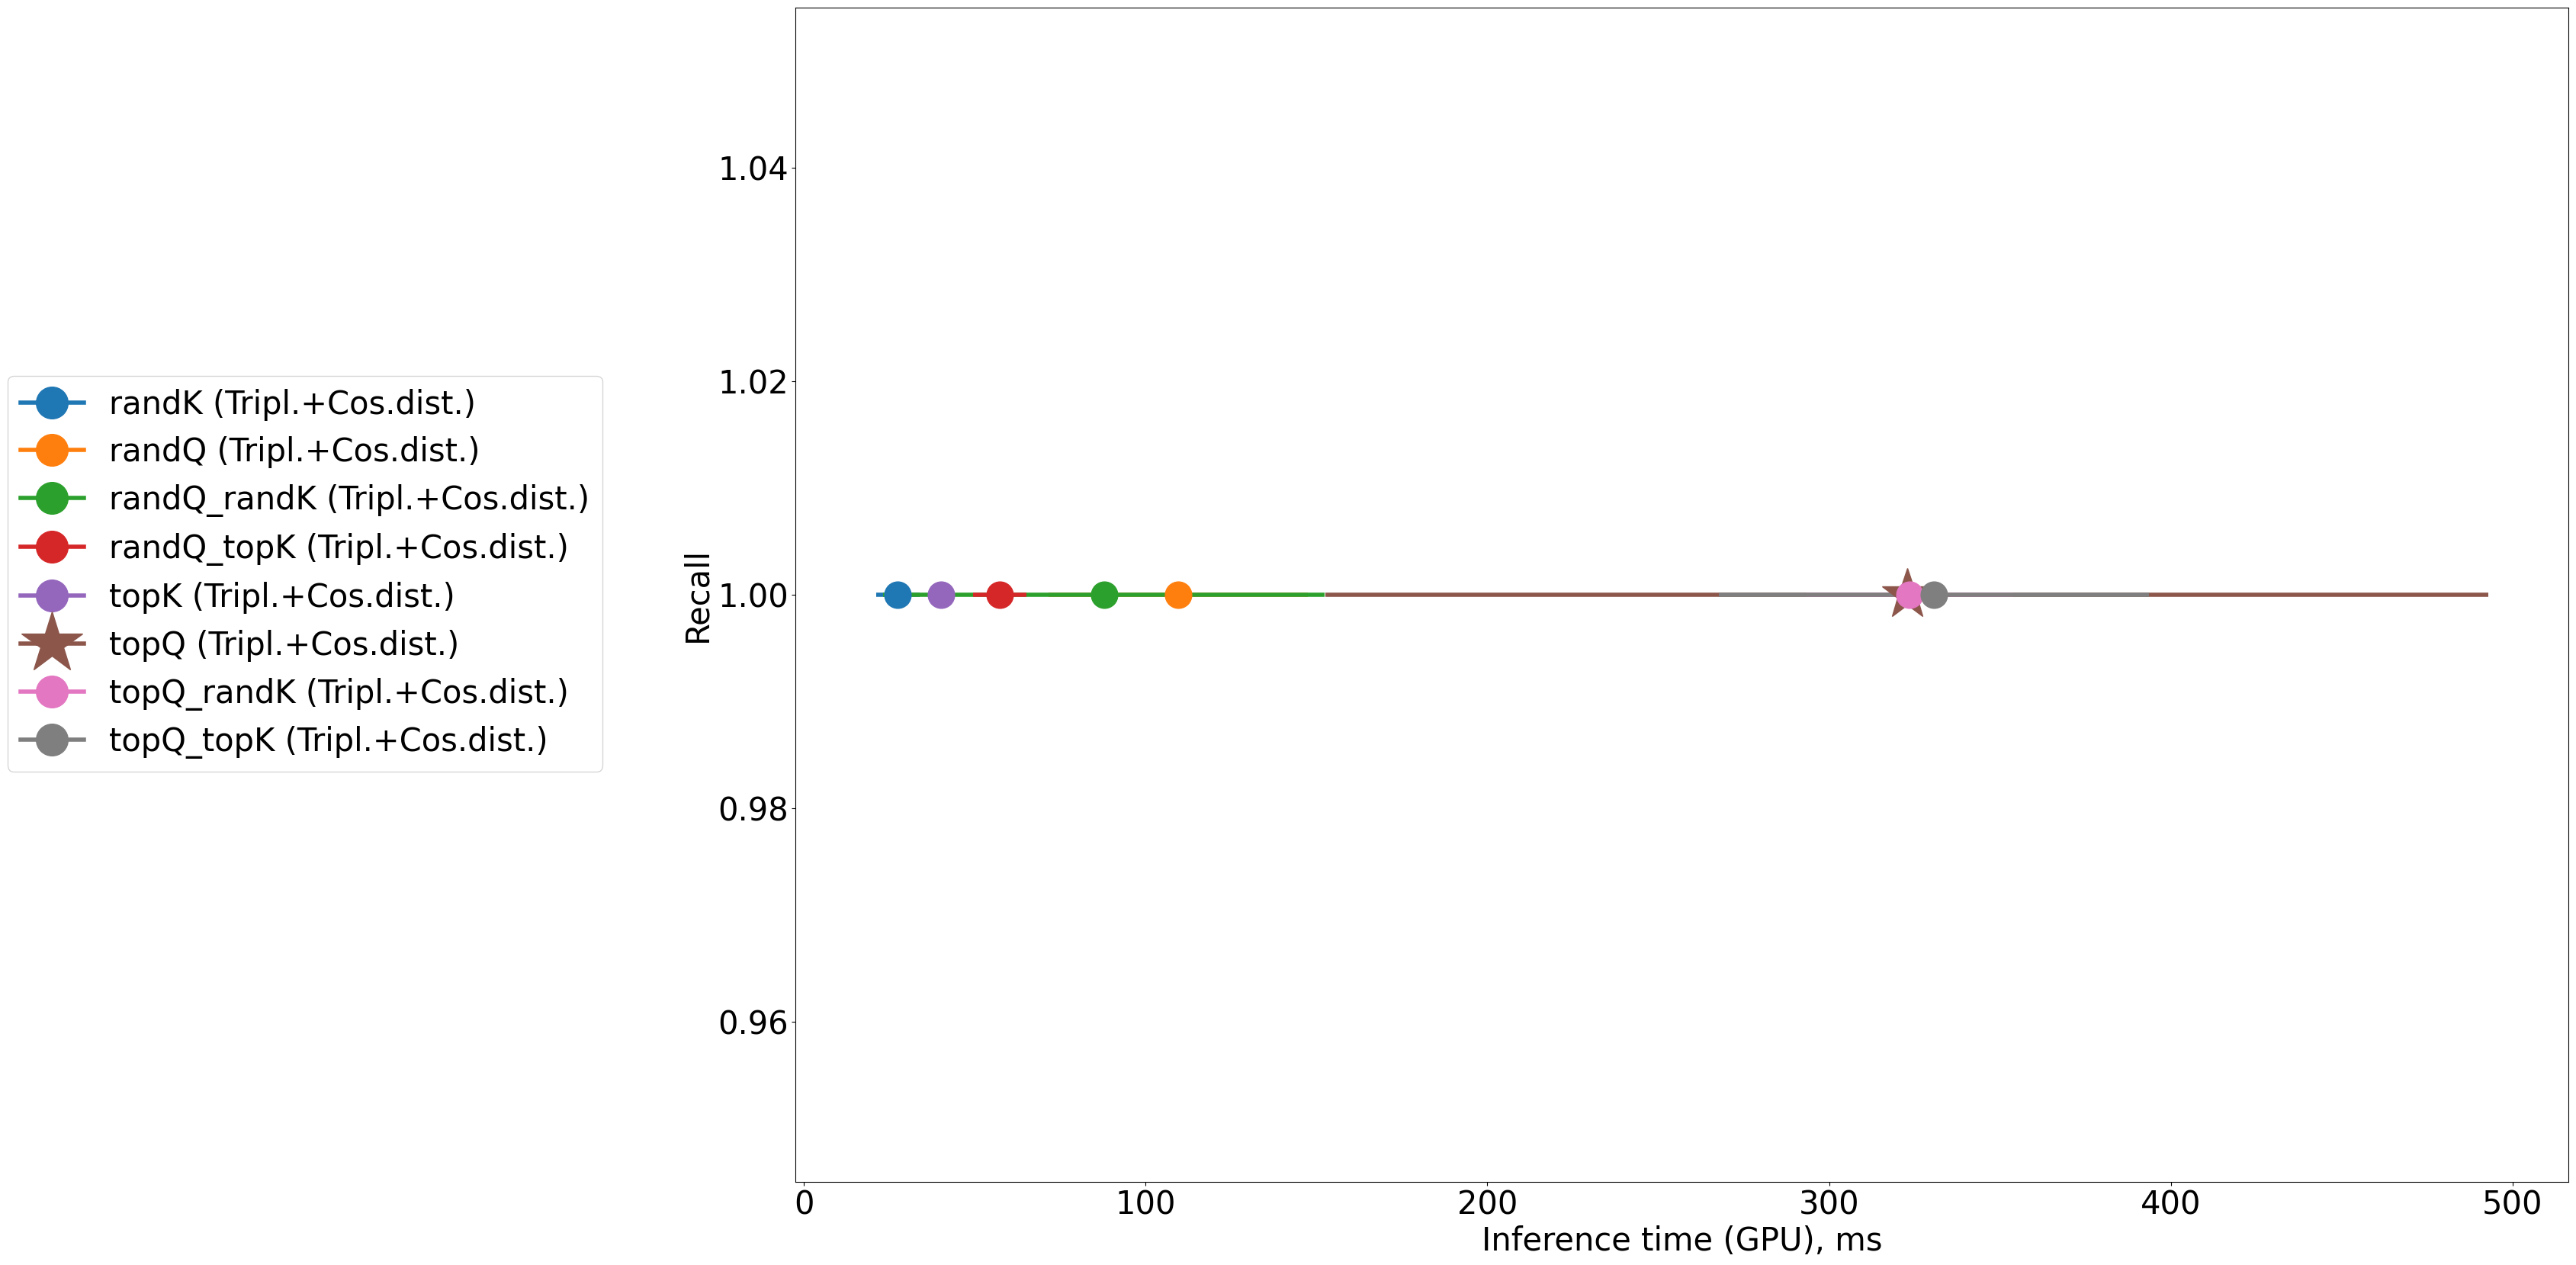

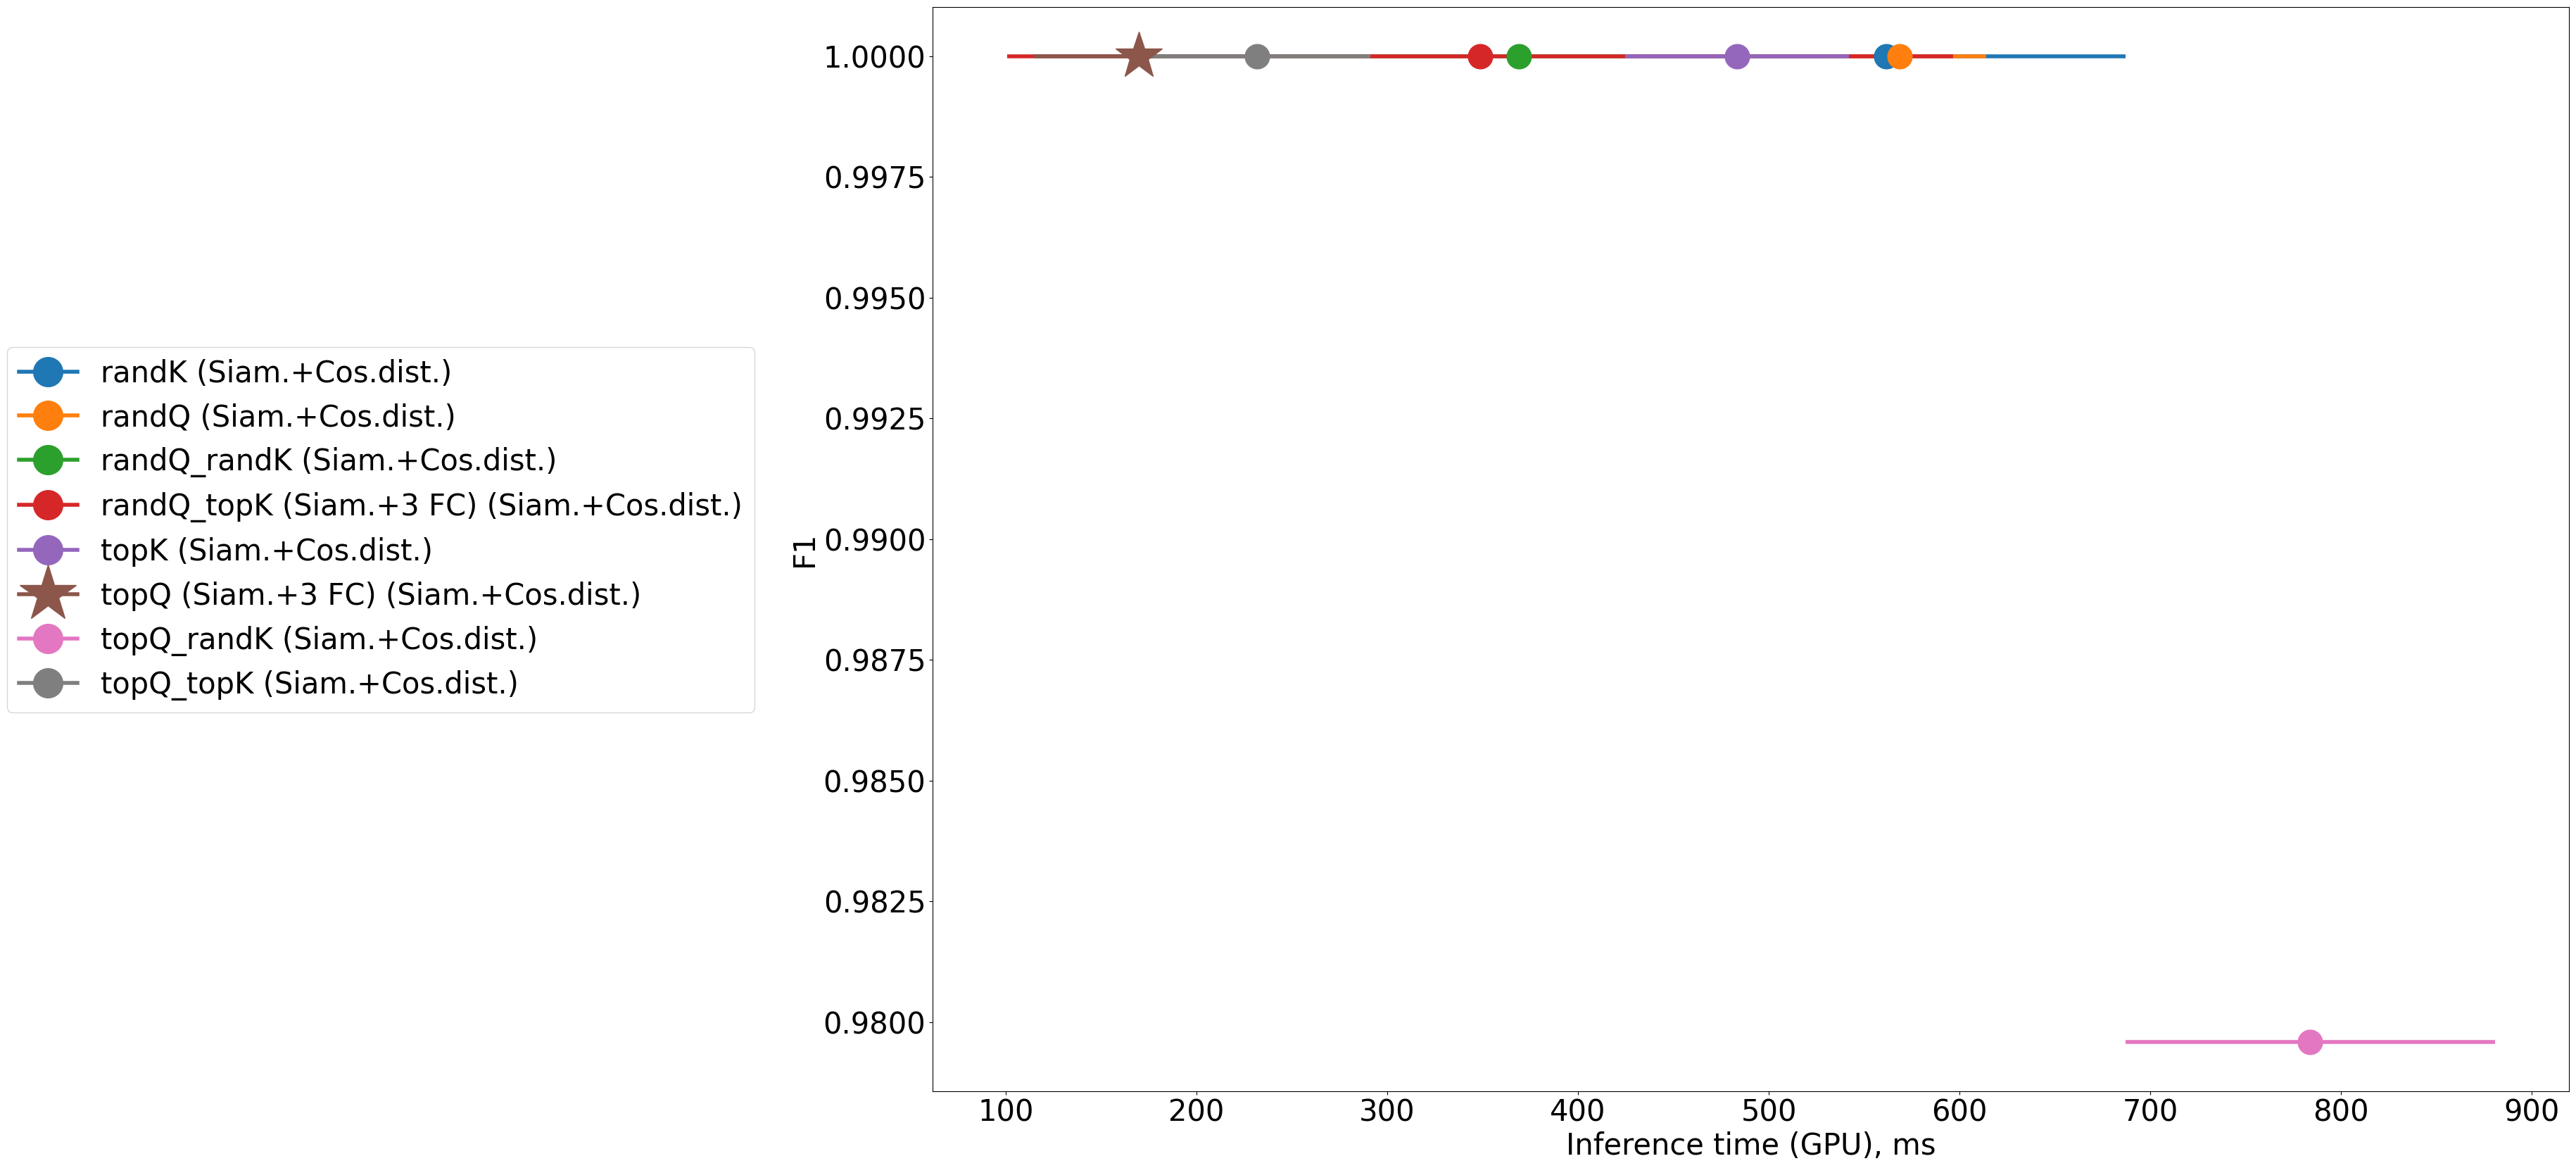

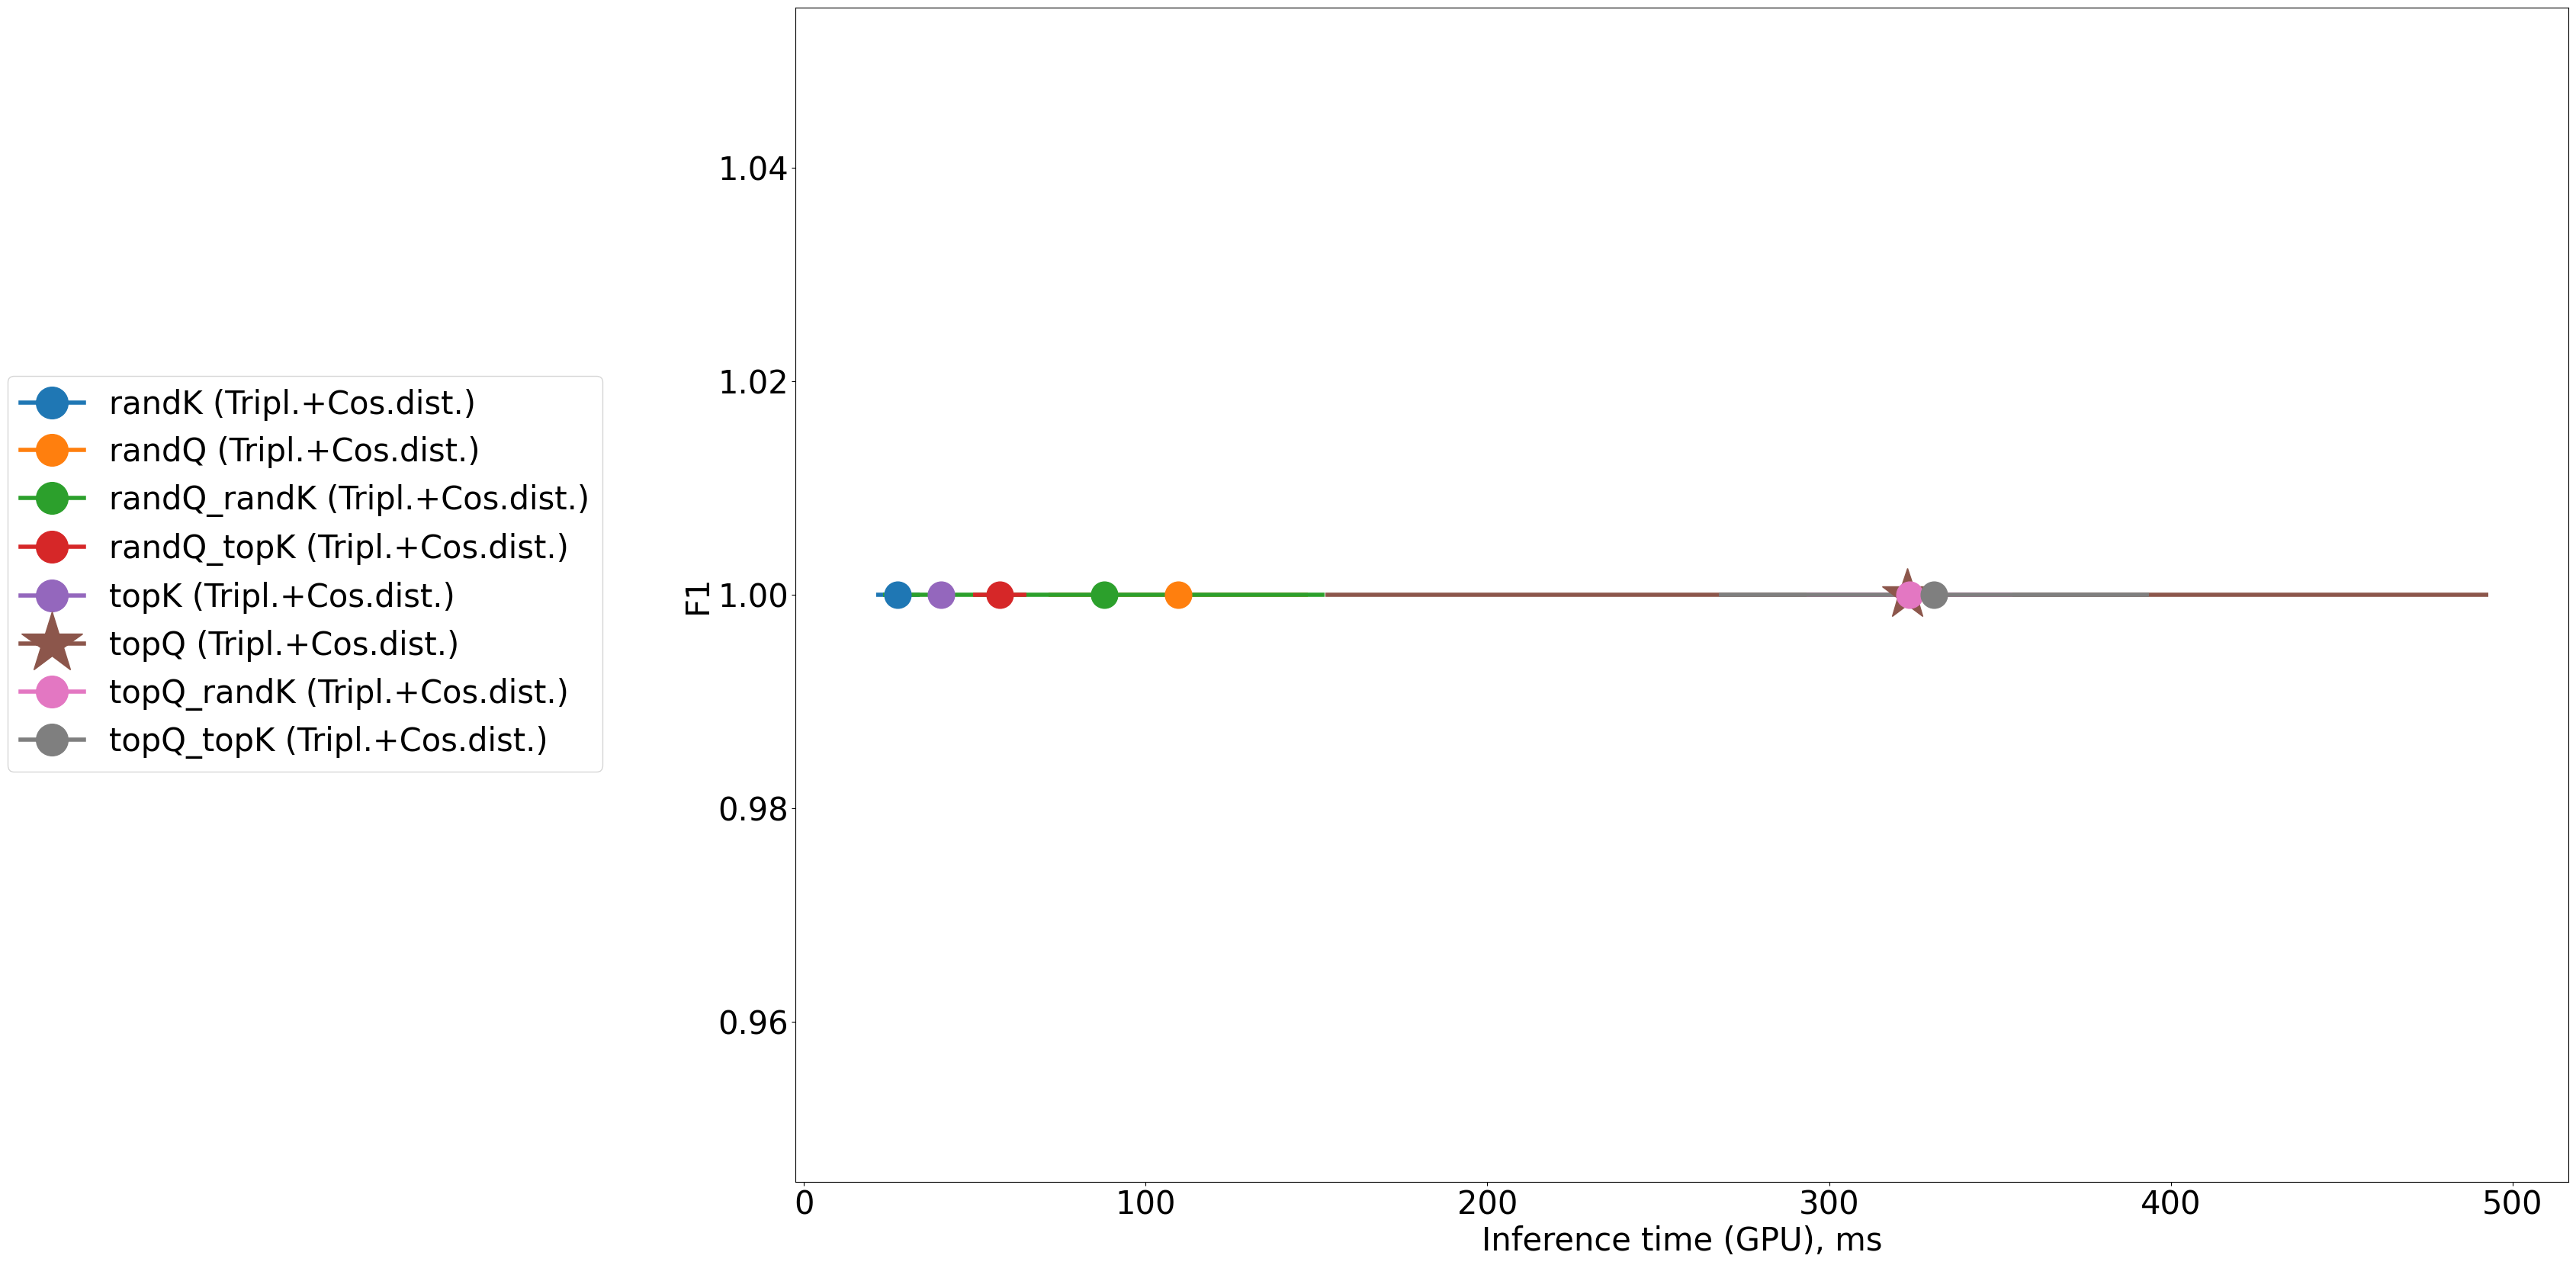

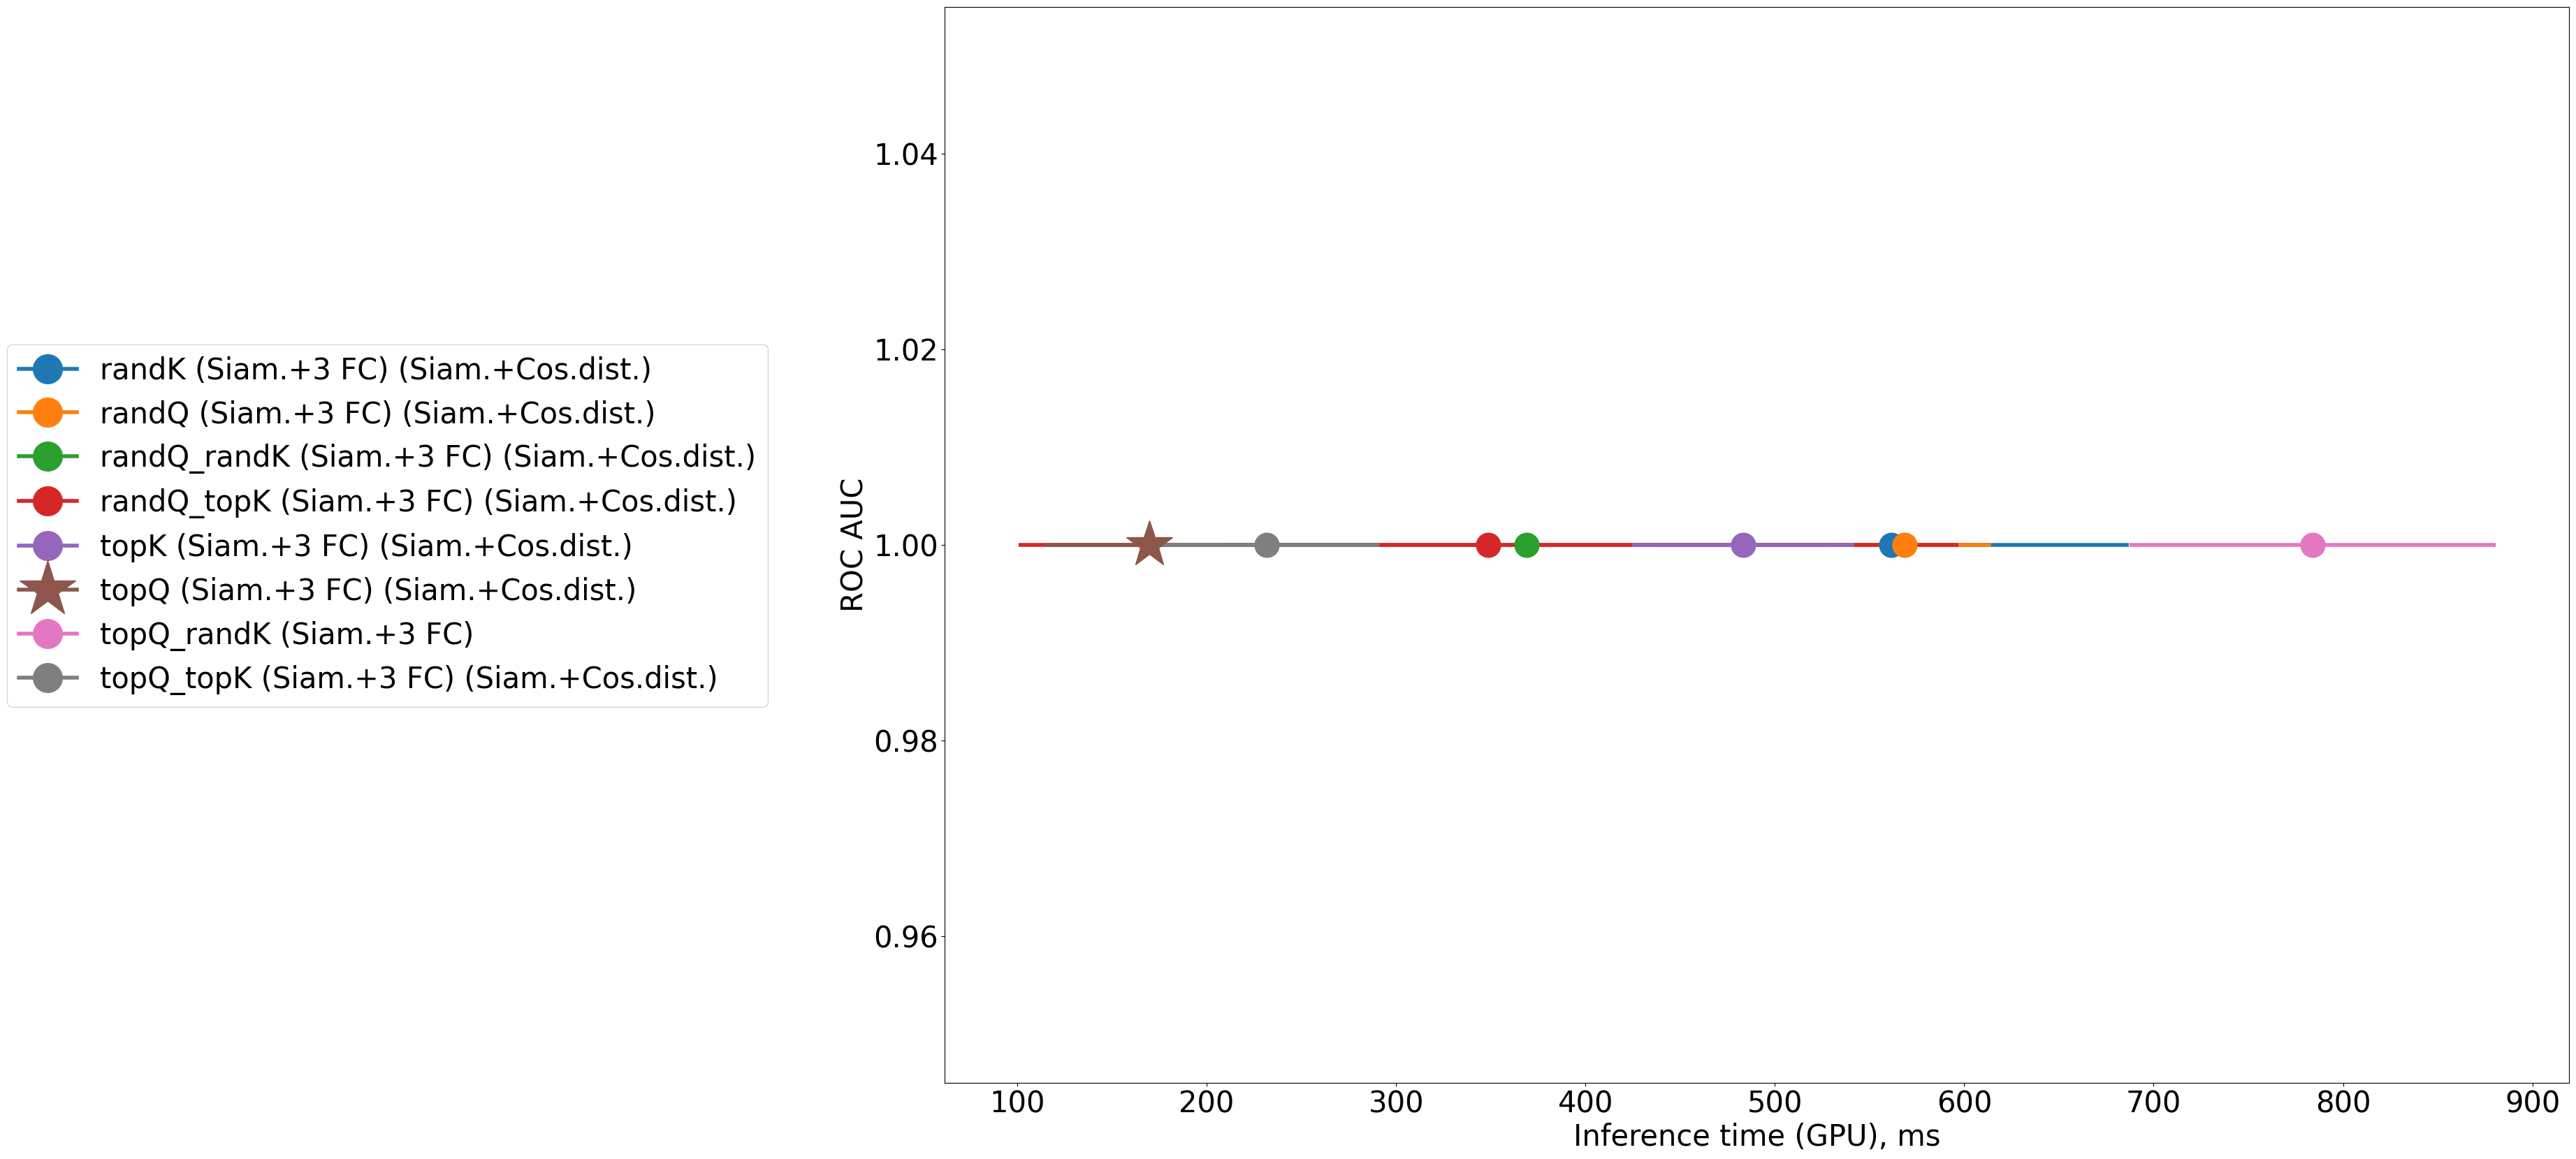

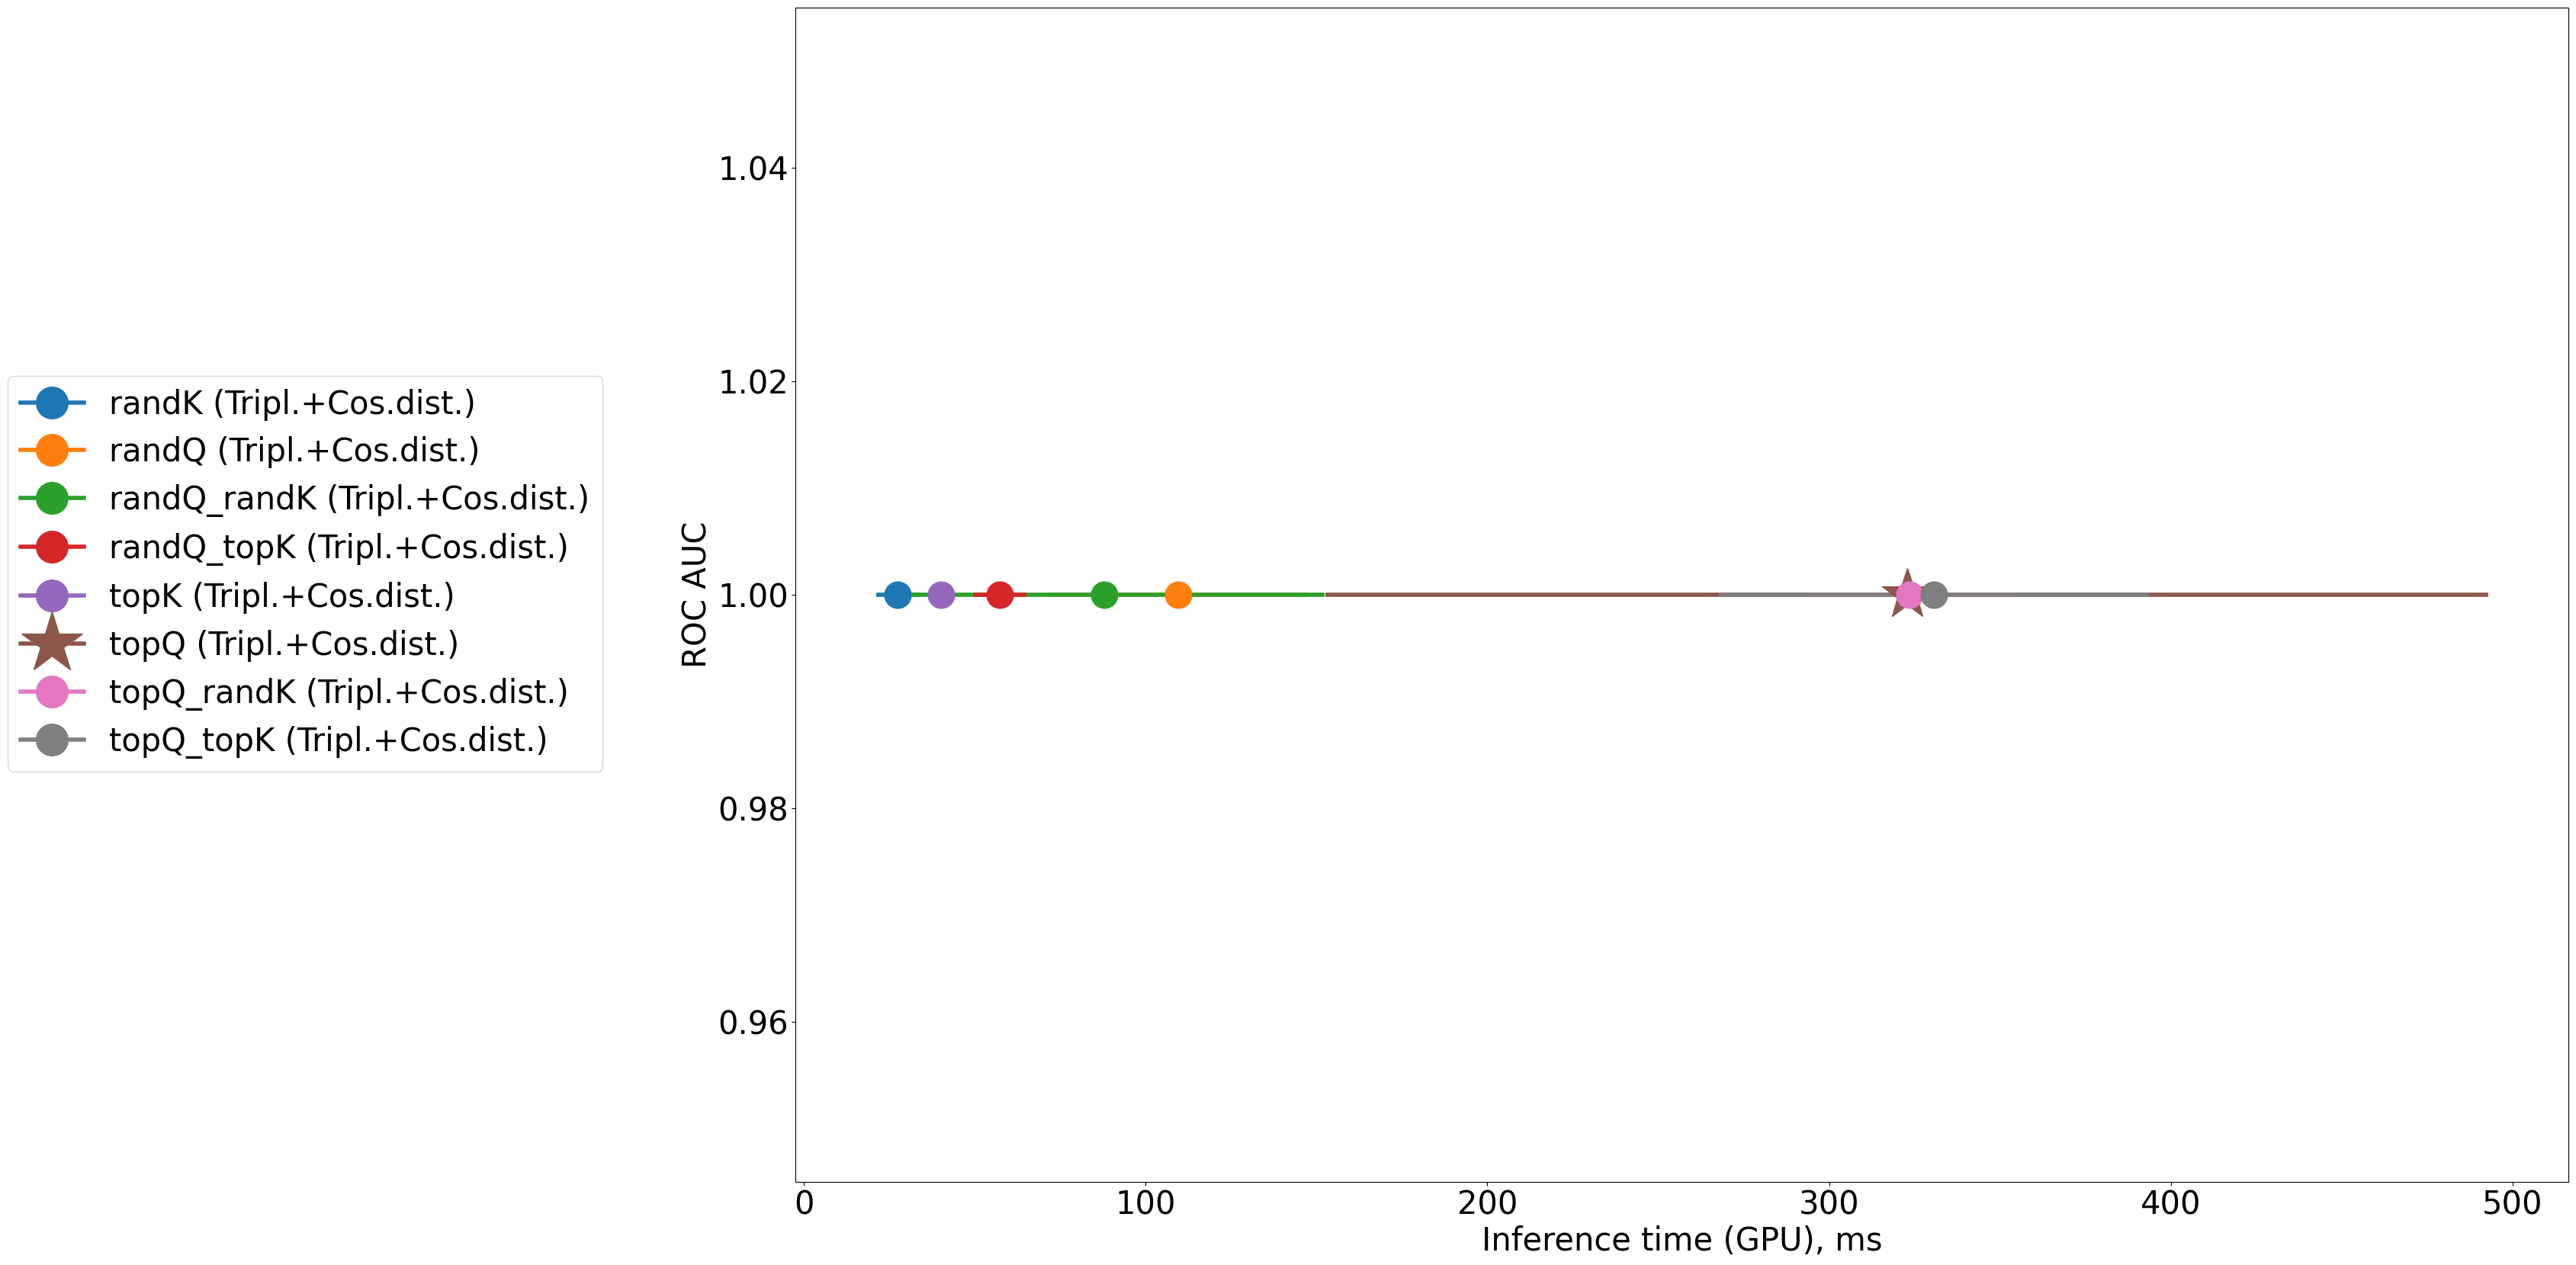

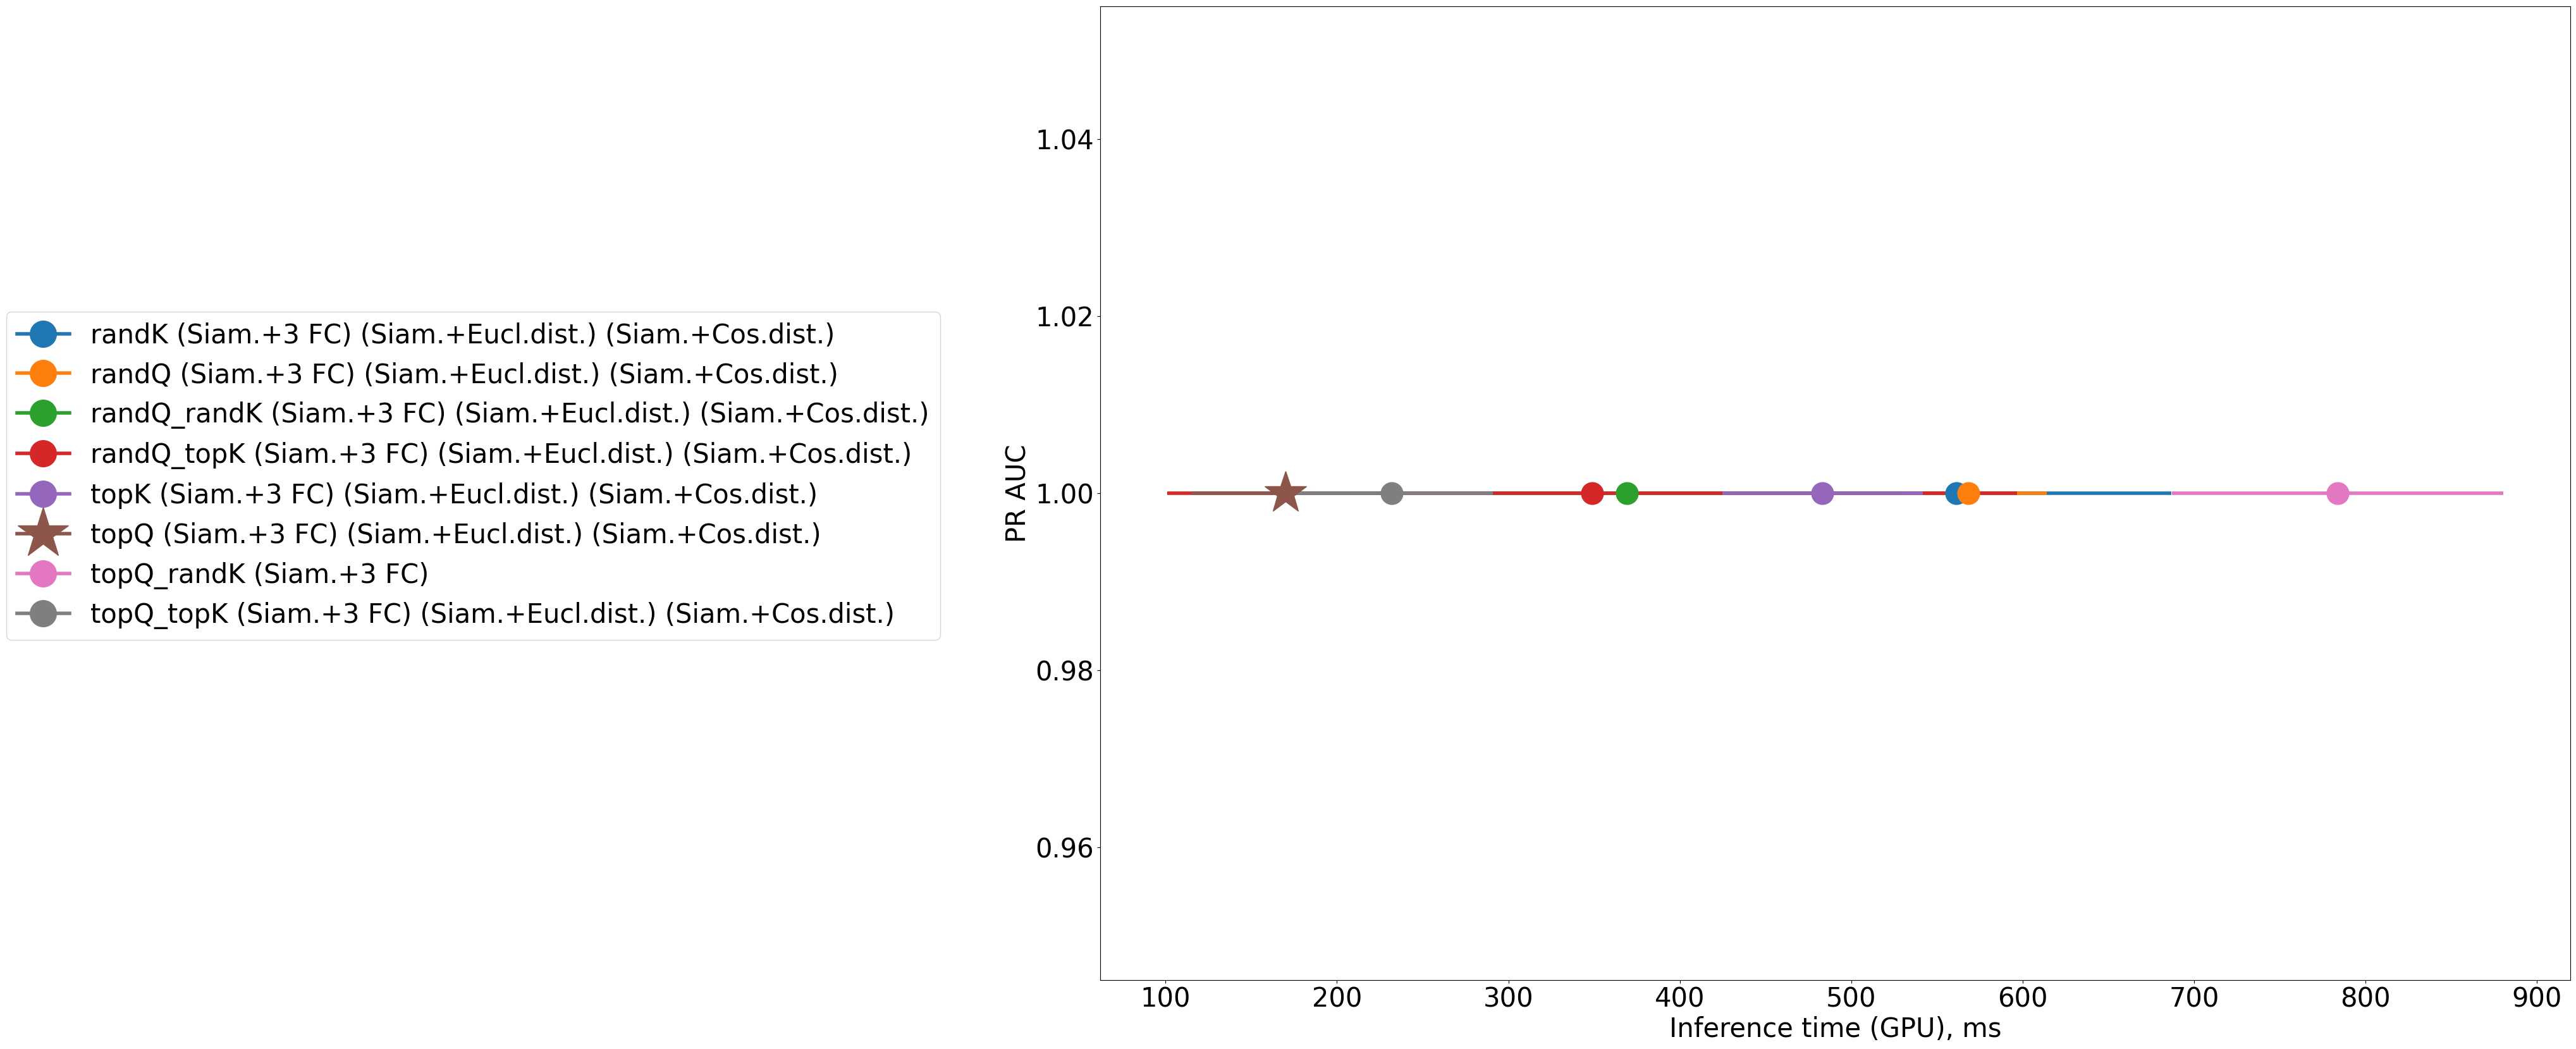

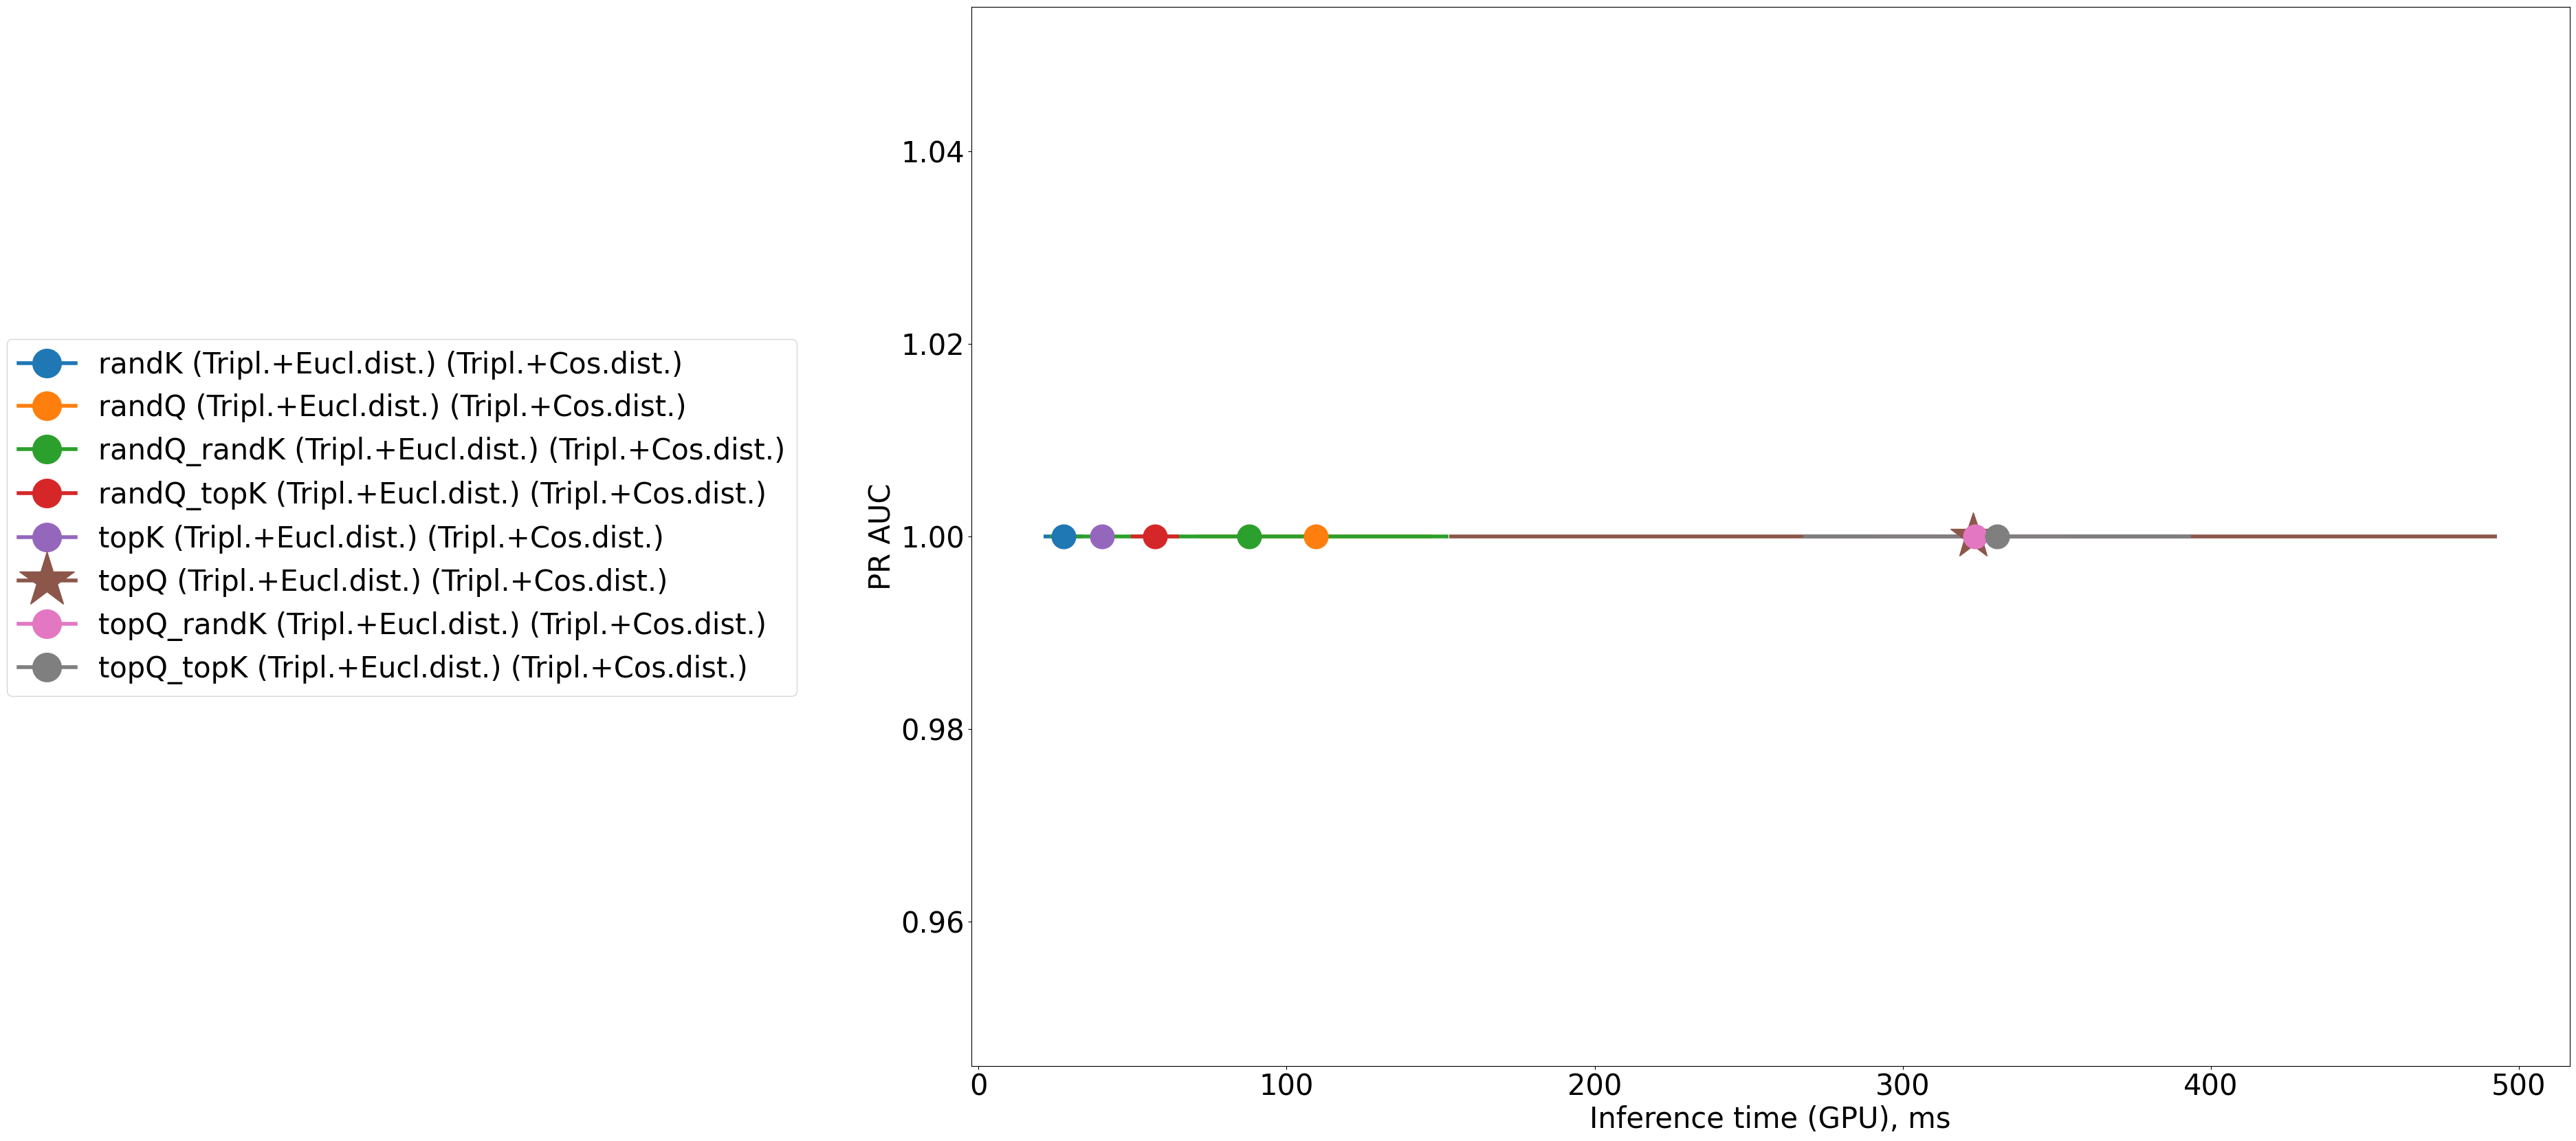

In [ ]:
for metric in main_metric_names:
    for i, (loss_type, data) in enumerate(all_res_df.groupby(by=["loss_type"])): 
        fig, ax = plt.subplots(1, 1, figsize=(30, 20))
        for j, (reg_type, df) in enumerate(data.groupby(by=["reg_type"])):
            marker = "o" 
            s_scale = 1
            if reg_type == "topQ":
                marker = "*" 
                s_scale = 2

            metric_array = np.array(
                [
                    df[metric].values[0], 
                    df["euclidean_" + metric].values[0], 
                    df["cosine_" + metric].values[0], 
                ]
            )
            label_legend = np.array(["(" + loss_type_legend_dict[loss_type] + d + ")" for d in ["+3 FC", "+Eucl.dist.", "+Cos.dist."]])
            indices = np.where(metric_array == np.nanmax(metric_array))
            curr_label_legend = " ".join(label_legend[indices[0]])
                
            ax.errorbar(
                df["gpu_inference_time_mean"].values, 
                [metric_array[indices[0][0]]], 
                xerr=df["gpu_inference_time_std"].values,
                lw=4,
                label=reg_type + " " + curr_label_legend,
                color="C{}".format(j),
                marker=marker,
                markersize=25 * s_scale,
            )
            ax.legend(markerscale=1.2, bbox_to_anchor=(-0.1, 0.7), ncol=1)
            ax.set_xlabel("Inference time (GPU), ms")
            ax.set_ylabel(metric)
        
        plt.savefig(
            os.path.join(saves_all_res, "{}_{}.png".format(loss_type, metric)),
            dpi=500,
            bbox_inches="tight",
        )